### Постановка задачи

**Задача**  

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

* `course_project_train.csv` - обучающий датасет
* `course_project_test.csv` - тестовый датасет

**Целевая переменная**

* `Credit Default` - факт невыполнения кредитных обязательств

**Метрика качества**

* `F1-score` (sklearn.metrics.f1_score)

**Требования к решению**

* Целевая метрика F1 > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

**Решение должно содержать**

* Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу `{ФИО}_solution.ipynb`, пример `SShirkin_solution.ipynb`
* Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу `{ФИО}_predictions.csv`, пример `SShirkin_predictions.csv`
* Рекомендации для файла с кодом (ipynb)
* Файл должен содержать заголовки и комментарии (markdown)
* Повторяющиеся операции лучше оформлять в виде функций
* Не делать вывод большого количества строк таблиц (5-10 достаточно)
* По возможности добавлять графики, описывающие данные (около 3-5)
* Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
* Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
* Весь проект должен быть в одном скрипте (файл ipynb).
* Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.


**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара. Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества. Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

### Примерное описание этапов выполнения курсового проекта

**Построение модели классификации**

1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

### Подключение библиотек и загрузка данных

In [136]:
# !pip install xgboost, lightgbm, catboost, ipywidgets, imblearn, featuretools 

In [137]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import pickle
from pathlib import Path

from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from scipy.stats import shapiro, probplot, mannwhitneyu, chi2_contingency

from catboost import CatBoostClassifier, CatBoostRegressor

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# rcParams['figure.figsize'] = 10, 8
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns = 100

In [138]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [139]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [140]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [141]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (9, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [142]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (9, 4))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [143]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(9,6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [144]:
DATA_ROOT = Path('./')
MODELS_PATH = Path('./models/')

# input
TRAIN_DATASET_PATH = DATA_ROOT / 'course_project_train.csv'
TEST_DATASET_PATH = DATA_ROOT / 'course_project_test.csv'

# output
PREPARED_TRAIN_DATASET_PATH = DATA_ROOT / 'train_prepared.csv'
PREPARED_TEST_DATASET_PATH = DATA_ROOT / 'test_prepared.csv'

MODEL_FILE_PATH = MODELS_PATH / 'model.pkl'

# TRAIN_DATASET_PATH='course_project_train.csv'
# TEST_DATASET_PATH='course_project_test.csv'

In [145]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)
* Credit Score - Кредитный балл

In [146]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [147]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [148]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Обзор данных

**Обзор целевой переменной**

In [149]:
target_values = df_train['Credit Default'].value_counts()
target_values

0    5387
1    2113
Name: Credit Default, dtype: int64

Определим дисбаланс целевой переменной, далее будем использовать для финальной модели

In [150]:
disbalance = df_train['Credit Default'].value_counts()[0] / df_train['Credit Default'].value_counts()[1]
disbalance

2.549455750118315

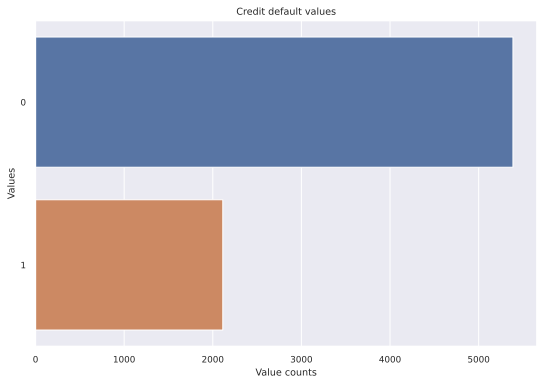

In [151]:
plt.figure(figsize=(9, 6))

sns.barplot(target_values.values, target_values.index, orient='h')
plt.title('Credit default values')
plt.xlabel('Value counts')
plt.ylabel('Values')
plt.show()

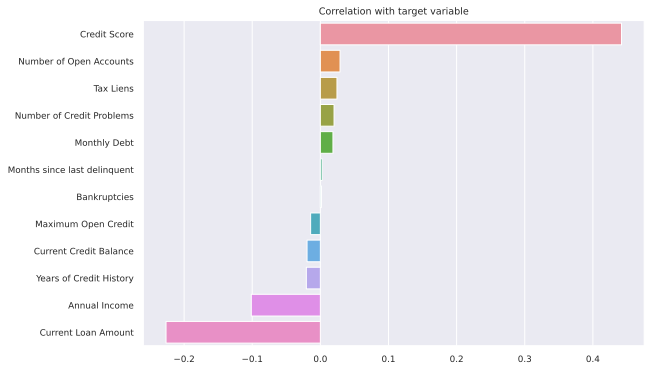

In [152]:
#Корелляция с базовыми признаками

TARGET = 'Credit Default'
FEATURES = df_train.columns.drop(TARGET).tolist()

corr_with_target = df_train[FEATURES + [TARGET]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(9, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Целевая переменная коррелирует с Credit Score и Current Loan Amount

**Обзор количественных признаков**

In [153]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


* `Annual Income` - есть пропущенные значения / возможно, поле связано с Years in current job
* `Tax Liens` значения по большей части - нули. 
* `Number of Open Accounts` - есть выбросы (> 25) (Оставлю, как есть)
* `Years of Credit History` - есть очень большие значения, пока оставим
* `Maximum Open Credit` - есть нулевые значения, они противоречат значениям текущей задолженности, есть выбросы
* `Current Loan Amount` - есть выбросы
* `Current Credit Balance` 
* `Monthly Debt` - есть корелляция с доходом
* `Number of Credit Problems`  
? * `Months since last delinquent` - много пропущенных значений.
? * `Bankruptcies` - есть немного пропусков
* `Credit Score` - много пропусков, корелляция с целевой переменной

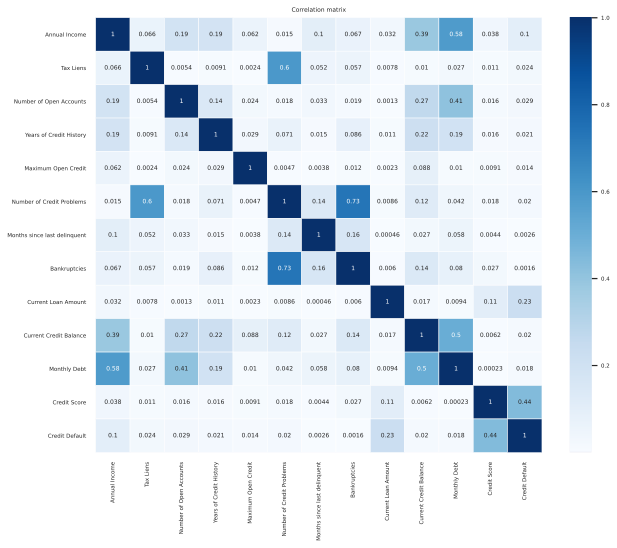

In [154]:
df_train.corr()
plt.figure(figsize=(10,8))

sns.set(font_scale=0.5)
sns.heatmap(df_train.corr().abs(), annot=True, linewidth=.5, cmap='Blues')
plt.title('Correlation matrix')
plt.show()

Наблюдается корреляция у следующих признаков: 
* `Number of Credit Problems` - `Bankruptcies` - 0,73
* `Number of Credit Problems` - `Tax Liens` - 0,6
* `Annual Income` - `Monthly Debt` - 0,58
* `Current Credit Balance` - `Monthly Debt` - 0,5
* `Credit Score` - `Credit Default` - 0,44
* `Number of Open Accounts` - `Monthly Debt` - 0,41
* `Annual Income` - `Current Credit Balance` - 0,39
* `Number of Open Accounts` - `Current Credit Balance` - 0,27
* `Years of Credit History` - `Current Credit Balance` - 0,22

In [155]:
df_train['Tax Liens'].value_counts().sort_values()

7.0       1
5.0       2
6.0       2
4.0       6
3.0      10
2.0      30
1.0      83
0.0    7366
Name: Tax Liens, dtype: int64

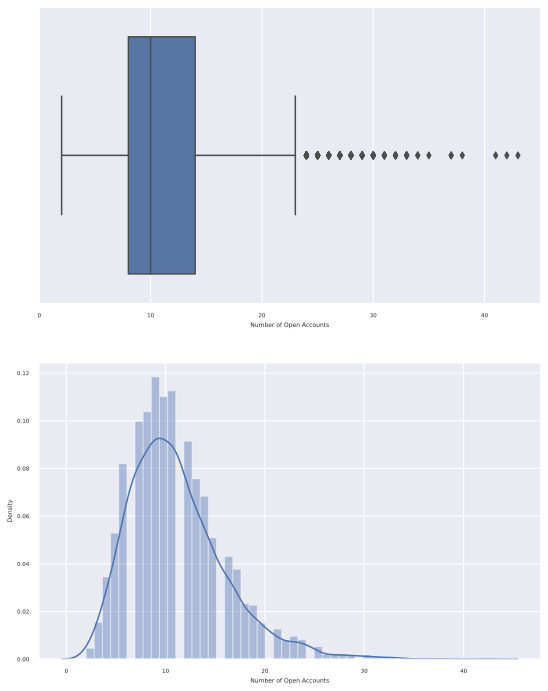

In [156]:
plt.figure(figsize=(9, 12))
plt.title('Number of Open Accounts distribution')

plt.subplot(211)
sns.boxplot(df_train['Number of Open Accounts'])
plt.xlabel('Number of Open Accounts')

plt.subplot(212)
sns.distplot(df_train['Number of Open Accounts'])
plt.xlabel('Number of Open Accounts')
plt.show()

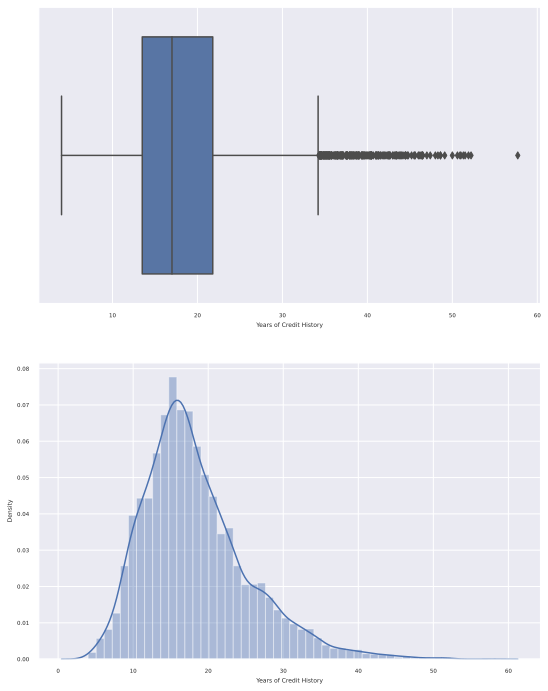

In [157]:
plt.figure(figsize=(9, 12))
plt.title('Number of Years of Credit History')

plt.subplot(211)
sns.boxplot(df_train['Years of Credit History'])
plt.xlabel('Years of Credit History')

plt.subplot(212)
sns.distplot(df_train['Years of Credit History'])
plt.xlabel('Years of Credit History')
plt.show()

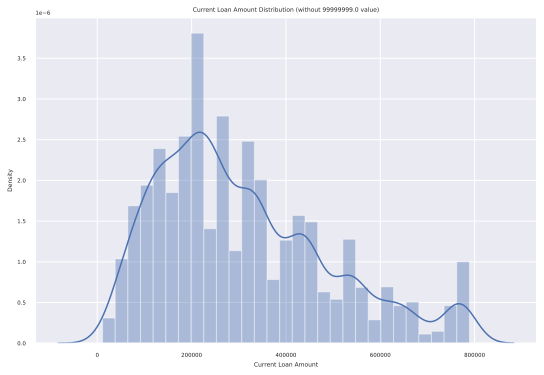

264616.0        1
186846.0        1
367334.0        1
290642.0        1
200640.0        1
             ... 
270226.0        5
216106.0        5
218064.0        6
89298.0         6
99999999.0    870
Name: Current Loan Amount, Length: 5386, dtype: int64


In [158]:
plt.figure(figsize=(9, 6))
plt.title('Current Loan Amount Distribution (without 99999999.0 value)')
plt.xlabel('Current Loan Amount')
plt.xlabel('Density')
sns.distplot(df_train['Current Loan Amount'].loc[df_train['Current Loan Amount'] < 99999999.0])
plt.show()
print(df_train['Current Loan Amount'].value_counts().sort_values())

In [159]:
df_train.loc[df_train['Maximum Open Credit'] > 10000000]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
44,Have Mortgage,1334256.0,10+ years,0.0,17.0,15.4,3.800523e+08,1.0,35.0,0.0,take a trip,Short Term,33110.0,656450.0,34357.0,729.0,0
354,Home Mortgage,2126537.0,10+ years,0.0,23.0,23.0,1.476048e+07,0.0,NaN,0.0,debt consolidation,Long Term,778624.0,1019806.0,40227.0,697.0,0
617,Home Mortgage,NaN,3 years,0.0,13.0,27.5,1.304726e+09,0.0,NaN,0.0,debt consolidation,Short Term,529892.0,1126814.0,5492.0,NaN,0
1476,Own Home,NaN,8 years,0.0,14.0,28.9,1.042866e+07,0.0,NaN,0.0,debt consolidation,Short Term,656766.0,1089802.0,16531.0,NaN,0
1879,Home Mortgage,1433835.0,6 years,0.0,8.0,17.8,1.270144e+07,0.0,35.0,0.0,debt consolidation,Short Term,197384.0,1985462.0,14099.0,749.0,0
2023,Rent,1342825.0,10+ years,0.0,12.0,16.3,5.756256e+07,0.0,NaN,0.0,other,Short Term,166826.0,944547.0,9176.0,749.0,0
2468,Home Mortgage,5589420.0,4 years,0.0,11.0,12.3,1.634591e+07,0.0,24.0,0.0,home improvements,Long Term,99999999.0,2315169.0,74991.0,735.0,0
2617,Home Mortgage,3217802.0,10+ years,0.0,12.0,35.5,2.655129e+08,0.0,NaN,0.0,other,Short Term,50116.0,1834450.0,20272.0,750.0,0
2763,Home Mortgage,3377440.0,10+ years,0.0,11.0,23.2,4.092389e+07,0.0,59.0,0.0,home improvements,Short Term,99999999.0,1908550.0,5770.0,743.0,0
3170,Home Mortgage,2226230.0,10+ years,0.0,20.0,19.0,1.868381e+07,0.0,NaN,0.0,buy a car,Short Term,111892.0,2355867.0,17123.0,750.0,0


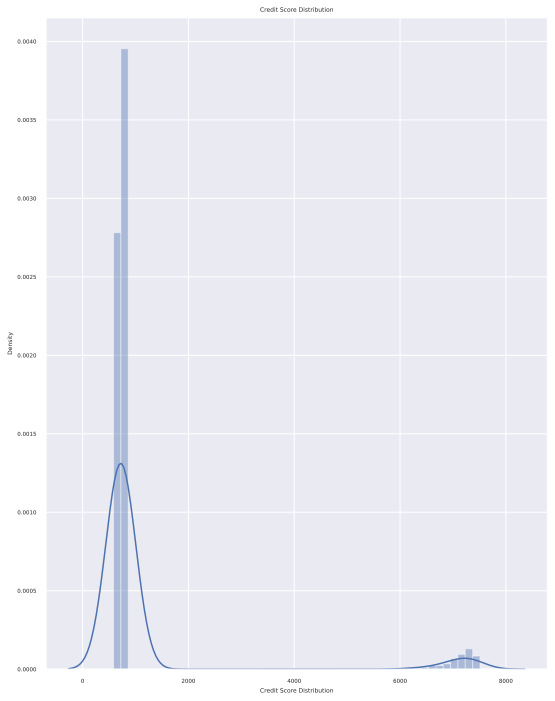

In [160]:
plt.figure(figsize=(9, 12))
plt.title('Credit Score Distribution')
sns.distplot(df_train['Credit Score'])
plt.xlabel('Credit Score Distribution')
plt.show()

Видно, что есть значения, которые находятся в другом интервале значений. Посмотрим на значения в разрезе целевой переменной.

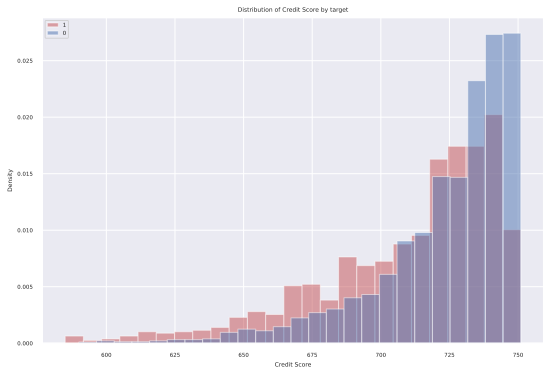

1184 1 values
4359 0 values


In [161]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] < 1000), 
             'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) &
             (df_train['Credit Score'] < 1000), 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

print("%d 1 values\n%d 0 values" % 
      (df_train.loc[(df_train['Credit Default'] == 1) & 
                    (df_train['Credit Score'] < 1000), 'Credit Score'].count(), 
                                   
       df_train.loc[(df_train['Credit Default'] == 0) & 
                    (df_train['Credit Score'] < 1000), 'Credit Score'].count()))
    


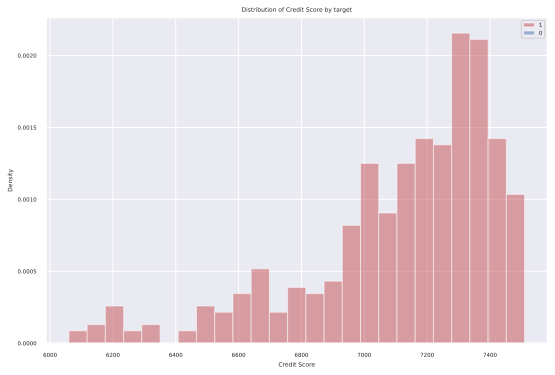

400 values


In [162]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) &
             (df_train['Credit Score'] > 1000), 
             'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) &
             (df_train['Credit Score'] > 1000), 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

print (df_train.loc[(df_train['Credit Default'] == 1) & 
                    (df_train['Credit Score'] > 1000), 'Credit Score'].count(), 'values')


* `Current Loan Amount` - Посмотрим на распределение значений в разрезе целевой переменной 

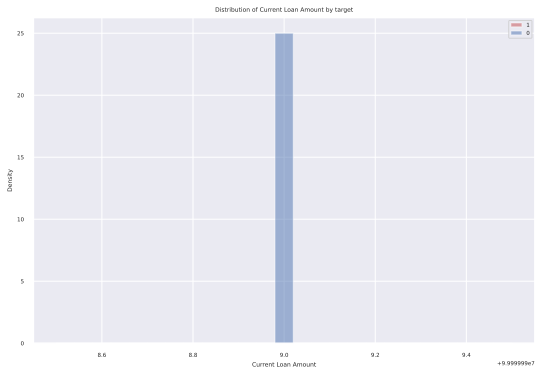

In [163]:
# 99999999.0

plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) & (df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) & (df_train['Current Loan Amount'] == 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Current Loan Amount')
plt.ylabel('Density')
plt.title('Distribution of Current Loan Amount by target')
plt.legend()
plt.show()

Видно, что все выбросные значения 99999999.0 имеют значения 0 колонки Credit Default, следовательно все пользователи с этим значением выплатили кредит. Посмотрим на распределение остальных значений

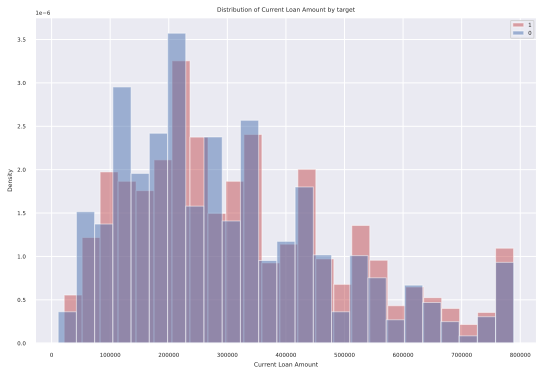

In [164]:
# < 99999999.0

plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) & (df_train['Current Loan Amount'] < 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) & (df_train['Current Loan Amount'] < 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Current Loan Amount')
plt.ylabel('Density')
plt.title('Distribution of Current Loan Amount by target')
plt.legend()
plt.show()

In [165]:
df_test.loc[(df_train['Credit Default'] == 1) & (df_train['Current Loan Amount'] == 99999999.0)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score


### Проверка распределения вещественных признаков на трейне и тесте

In [166]:
df_train.columns

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score', 'Credit Default'],
      dtype='object')

In [167]:
df_train['Maximum Open Credit'].value_counts()

0.0          65
319110.0      5
334796.0      3
607046.0      3
294030.0      3
             ..
534600.0      1
1026124.0     1
77066.0       1
780164.0      1
350768.0      1
Name: Maximum Open Credit, Length: 6963, dtype: int64

In [168]:
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 
                     'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                    'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score',
                    'Bankruptcies']

Annual Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


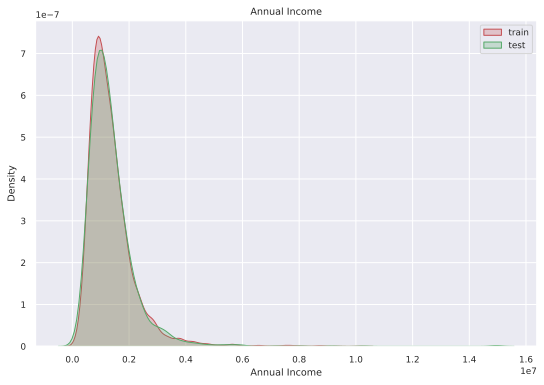

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


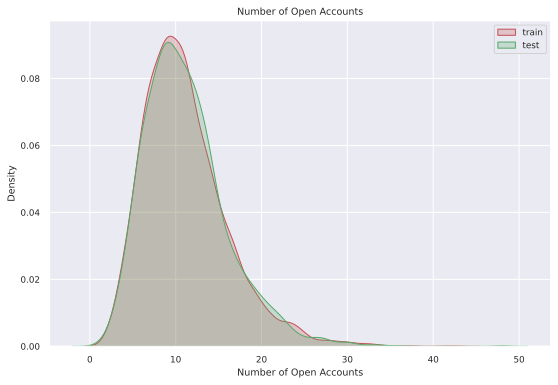

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


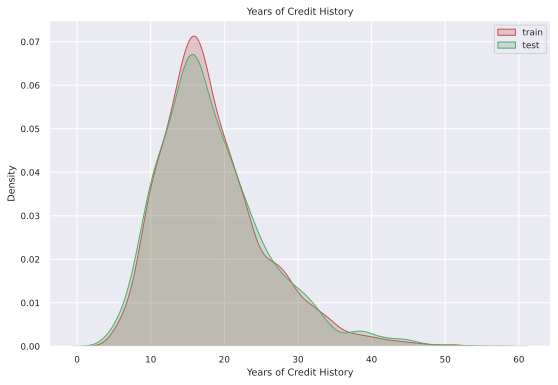

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


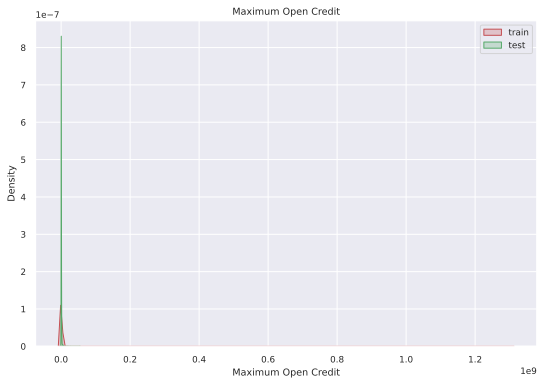

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


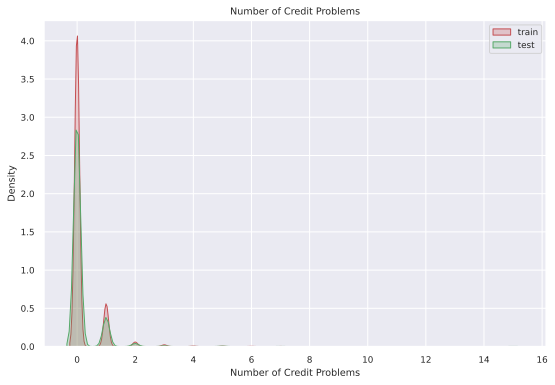

Months since last delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


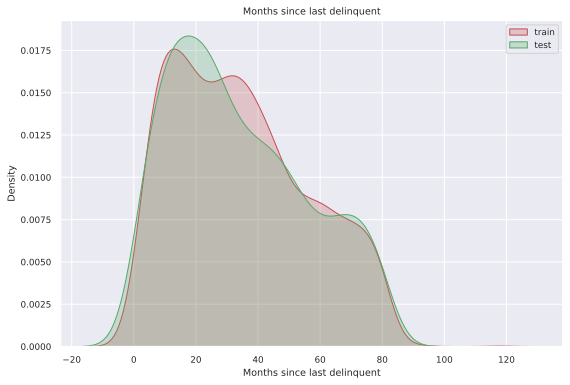

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


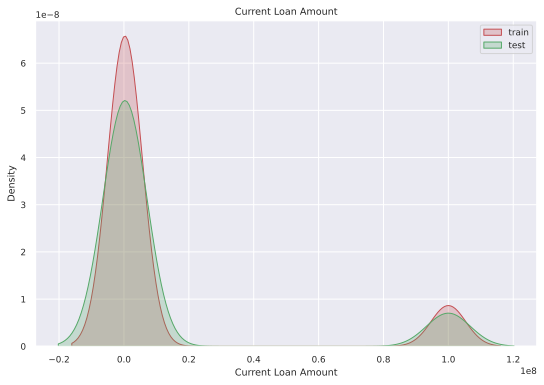

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


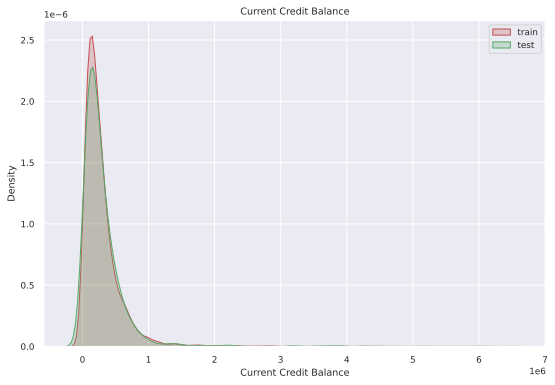

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


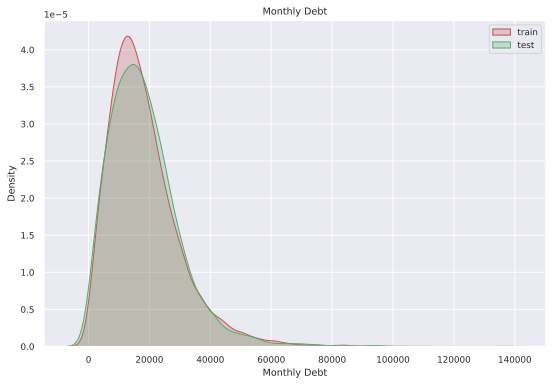

Credit Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


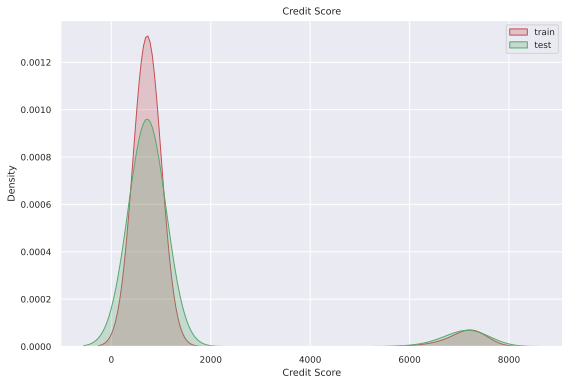

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


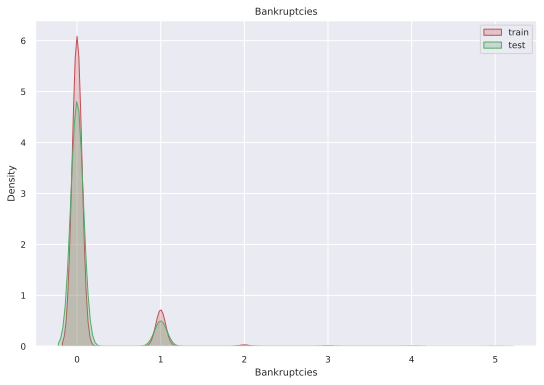

In [169]:
figsize = (9, 6)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

Значения в trein и test датасете совпадают в большинстве признаков
Признак 'Months since last delinquent' и 'Bankruptcies' имеют низкий p-value, соответственно данные в train и test выборках отличаются, возможно, есть выбросы

**Обзор категориальных признаков**

In [170]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

* `Home ownership` - Есть значение Have Mortgage, в котором всего 12 наблюдений (выбросы) и оно очень похоже на Home Mortgage, которое является самым часто встречающимся в датасете. заменим эти значения на mode()
* `Years in current job` - выбросов нет, больше всего значений 10+, можно сократить количество категорий по частоте проявления в целевой переменной
* `Purpose` - много категорий, сократим их количество по частоте проявления
* `Term` - здесь значения нормально распределены, выбросов нет

### Проверка распределения категориальных признаков на трейне и тесте

In [171]:
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems',
                   'Bankruptcies', 'Purpose', 'Term']

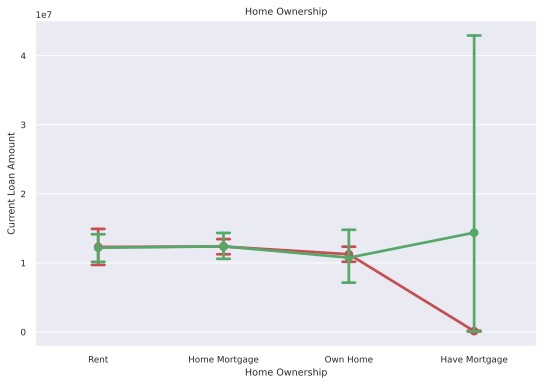

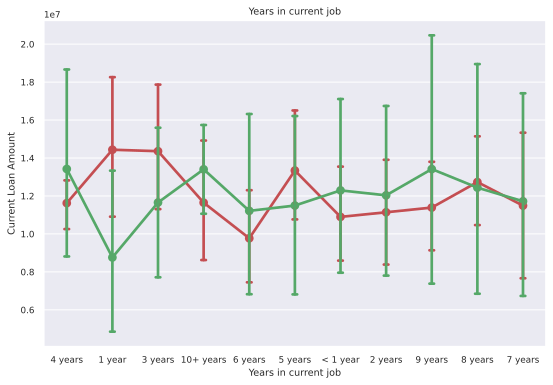

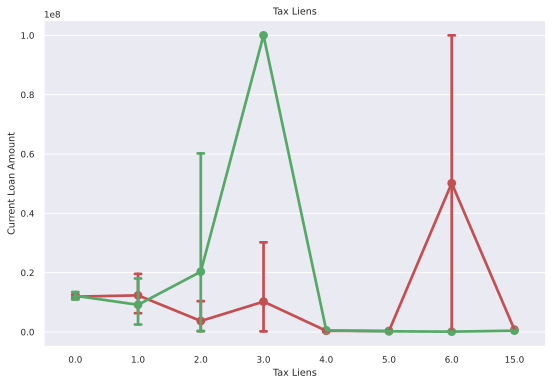

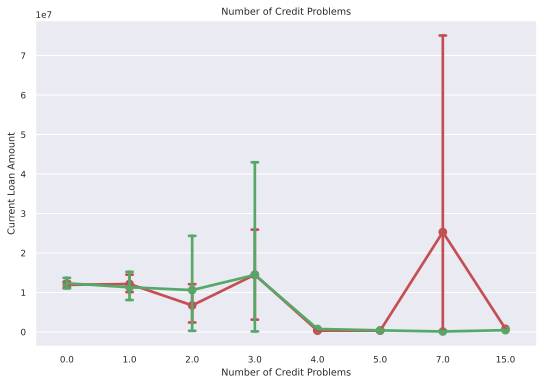

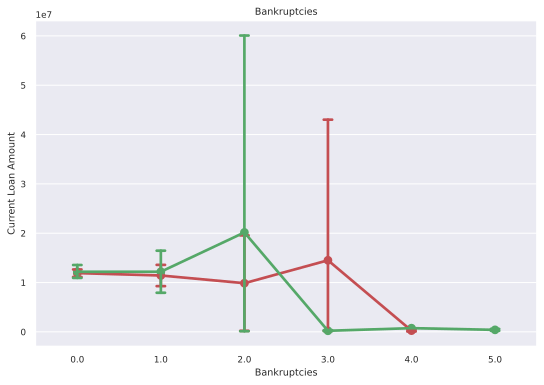

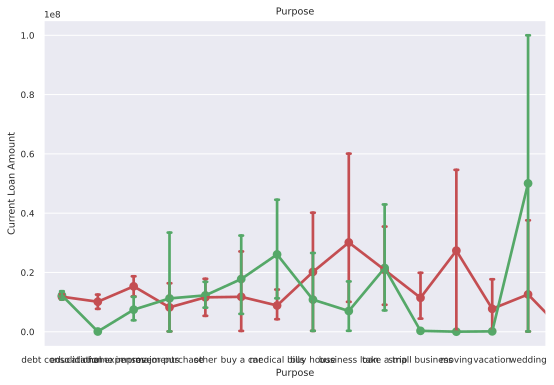

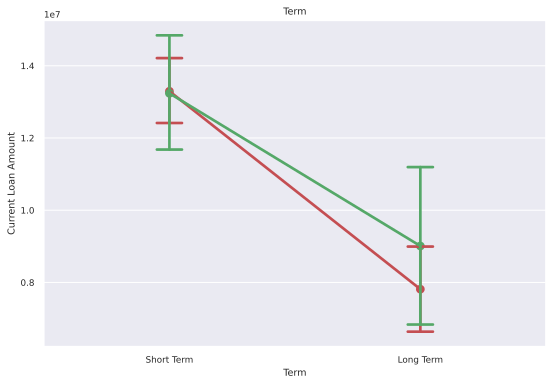

In [172]:
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y='Current Loan Amount', data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y='Current Loan Amount', data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

Данные в train и test похожи, есть признаки, в которых можно сократить количество категорий, Purpose, Years in Current Job

* `Months since last delinquent` - Изучим признак в разрезе целевой переменной, посмотрим на пропуски и выбросы

In [173]:
df_train['Months since last delinquent'].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

In [174]:
df_train.loc[df_train['Months since last delinquent'].isnull(), 'Credit Default'].value_counts()

0    2951
1    1130
Name: Credit Default, dtype: int64

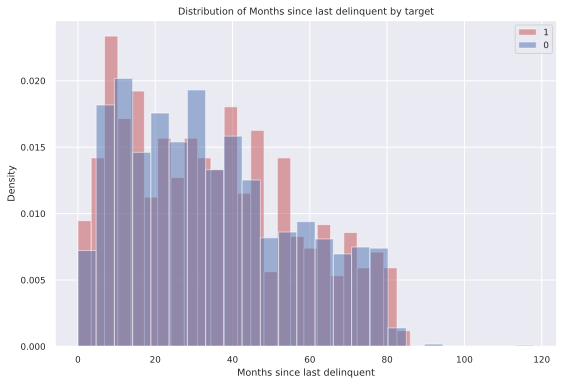

In [175]:
plt.figure(figsize = (9, 6))

df_train.loc[df_train['Credit Default'] == 1, 'Months since last delinquent'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[df_train['Credit Default'] == 0, 'Months since last delinquent'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Months since last delinquent')
plt.ylabel('Density')
plt.title('Distribution of Months since last delinquent by target')
plt.legend()
plt.show()

Признак не оказывает сильного влияния на целевую переменную, лучше его убрать из обучения 

* `Number of Credit Problems`, `Bankruptcies`

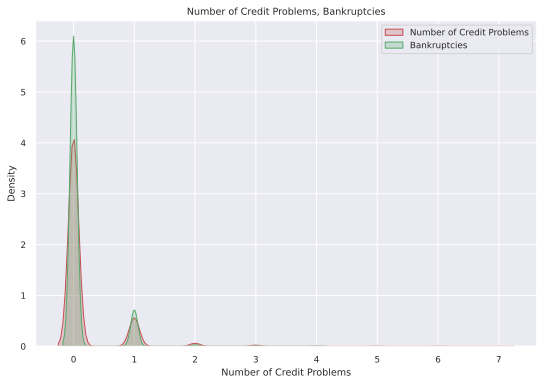

In [176]:
# train dataset
plt.figure(figsize=figsize)
sns.set(font_scale=0.8)
sns.kdeplot(df_train['Number of Credit Problems'], shade=True, label='Number of Credit Problems', color='r')
sns.kdeplot(df_train['Bankruptcies'].fillna(0), shade=True, label='Bankruptcies', color='g')
#     print(col)
#     print(mannwhitneyu(df_train[col], df_test[col]))
plt.legend()
plt.title('Number of Credit Problems, Bankruptcies' )
plt.show()

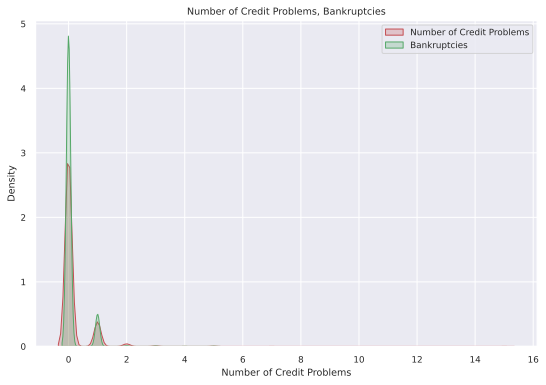

In [177]:
# test dataset
plt.figure(figsize=figsize)
sns.set(font_scale=0.8)
sns.kdeplot(df_test['Number of Credit Problems'], shade=True, label='Number of Credit Problems', color='r')
sns.kdeplot(df_test['Bankruptcies'].fillna(0), shade=True, label='Bankruptcies', color='g')
#     print(col)
#     print(mannwhitneyu(df_train[col], df_test[col]))
plt.legend()
plt.title('Number of Credit Problems, Bankruptcies')
plt.show()

На графике признаки `Number of Credit Problems` и `Bankruptcies` выглядят похожими.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух независимых выборках равны
* Альтернативная гипотеза: средние значения в двух независимых выборках различаются
* Критерий: критерий  Манна-Уитни
* Уровень значимости $\normalsize \alpha$: 0.05

In [178]:
mannwhitneyu(df_train['Number of Credit Problems'], df_train['Bankruptcies'])

MannwhitneyuResult(statistic=27374550.0, pvalue=3.8907975653337067e-07)

Значение p-value оказалось сильно меньше, чем уровень значимости $\normalsize \alpha$, соответственно, мы не можем принять нулевую гипотезу

* `Bankruptcies`

In [179]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

In [180]:
df_test['Bankruptcies'].value_counts()

0.0    2252
1.0     234
2.0       5
3.0       3
5.0       2
4.0       1
Name: Bankruptcies, dtype: int64

в тестовой выборке встречаются значения, которых нет в обучении

In [181]:
df_train.loc[df_train['Bankruptcies'] > 2]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
79,Rent,985815.0,8 years,0.0,11.0,18.1,227876.0,3.0,51.0,3.0,debt consolidation,Short Term,108504.0,104899.0,10351.0,729.0,1
754,Home Mortgage,2325828.0,2 years,0.0,12.0,17.6,403502.0,3.0,NaN,3.0,debt consolidation,Short Term,336644.0,88521.0,12269.0,735.0,1
1377,Home Mortgage,1040820.0,6 years,0.0,6.0,15.8,390060.0,3.0,76.0,3.0,debt consolidation,Long Term,99999999.0,121942.0,3573.0,719.0,0
2376,Rent,765586.0,NaN,0.0,8.0,16.0,273570.0,3.0,NaN,3.0,other,Short Term,245850.0,60002.0,2488.0,658.0,0
2480,Rent,1220066.0,< 1 year,0.0,25.0,12.9,588478.0,3.0,NaN,3.0,debt consolidation,Short Term,347732.0,289693.0,19216.0,743.0,0
4223,Rent,918517.0,10+ years,0.0,3.0,19.8,81070.0,4.0,78.0,4.0,debt consolidation,Short Term,74888.0,2375.0,7501.0,713.0,0
4987,Home Mortgage,954180.0,4 years,0.0,15.0,28.8,573276.0,3.0,66.0,3.0,debt consolidation,Short Term,331452.0,114361.0,21469.0,737.0,0
5675,Home Mortgage,848122.0,NaN,0.0,9.0,16.2,790548.0,3.0,68.0,3.0,debt consolidation,Short Term,220682.0,350246.0,14135.0,746.0,0
5788,Rent,3034224.0,3 years,0.0,10.0,16.7,307582.0,4.0,NaN,4.0,debt consolidation,Long Term,418858.0,137066.0,17295.0,692.0,1


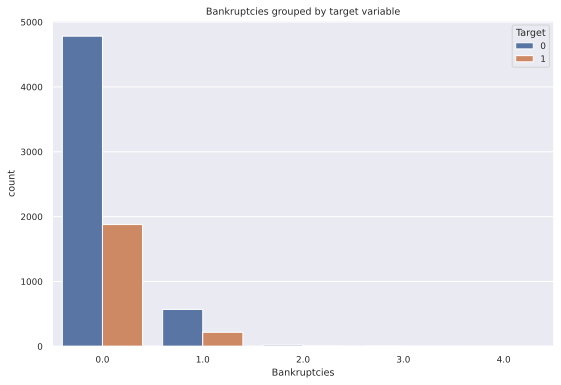

In [182]:
plt.figure(figsize=(9, 6))

sns.countplot(x='Bankruptcies', hue='Credit Default', data=df_train)
plt.title('Bankruptcies grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

* `Years in current job`

In [183]:
df_train['Years in current job'].isnull().sum()

371

Посмотрим на признак 'Years in current job' в разрезе целевой переменной

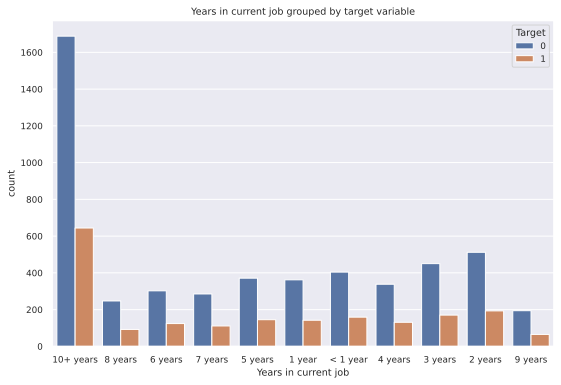

In [184]:
plt.figure(figsize=(9, 6))

sns.countplot(x='Years in current job', hue='Credit Default', data=df_train)
plt.title('Years in current job grouped by target variable')
plt.legend(title='Target', loc='upper right')

plt.show()

In [185]:
df_train.groupby('Years in current job')['Credit Default'].mean().sort_values()

Years in current job
9 years      0.250965
8 years      0.271386
2 years      0.273759
3 years      0.274194
10+ years    0.276158
4 years      0.279318
7 years      0.280303
5 years      0.281008
1 year       0.281746
< 1 year     0.282416
6 years      0.291080
Name: Credit Default, dtype: float64

**Наблюдение**

Изучив получившийся график и распределение частот, видно, что значения 2 years, 3 years имеют схожие доли в разрезе целевой переменной. Если это действительно так, то можно будет, например, объединить их в одну категорию.

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05

Для проверки данной гипотезы необходимо подать наблюдаемые частоты категорий 2 years, 3 years и 4 years признака `Years in current job` в выбранный критерий, после чего оценить значение достигаемого уровня значимости p-value и сравнить с его с выбранным порогом альфа, если p-value получится больше выбранного порога, то гипотезу о согласованности частот можно не отбрасывать.

*Рассчитаем наблюдаемые частоты*

In [186]:
# 2 years, 3 years, 8 years
df_train['Id'] = df_train.index
years_and_target = df_train.loc[df_train['Years in current job'].isin([ '2 years', '3 years', '8 years']), ['Id', 'Years in current job', 'Credit Default']]
table = years_and_target.pivot_table(values='Id', index='Years in current job', columns='Credit Default', aggfunc='count')
table

Credit Default,0,1
Years in current job,,
2 years,512,193
3 years,450,170
8 years,247,92


*Проверим нашу гипотезу, используя критерий Хи-квадрат Пирсона*

In [187]:
chi2, p, _, _ = chi2_contingency(table)
p

0.9953464771488197

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что категории 2 и 3 одинаково влияют на целевую переменную и их можно объединить в одну категорию. 

Аналогично проверим другие значения: 

In [188]:
# 5 years, 6 years,7 years & 4 years
df_train['Id'] = df_train.index
years_and_target = df_train.loc[df_train['Years in current job'].isin(['4 years','5 years', '6 years', '7 years']), ['Id', 'Years in current job', 'Credit Default']]
table = years_and_target.pivot_table(values='Id', index='Years in current job', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.9788101799519685

In [189]:
# 10+ years & 9 years
df_train['Id'] = df_train.index
years_and_target = df_train.loc[df_train['Years in current job'].isin(['10+ years', '9 years']), ['Id', 'Years in current job', 'Credit Default']]
table = years_and_target.pivot_table(values='Id', index='Years in current job', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.4299373704294749

In [190]:
# < 1 year & 1 year
df_train['Id'] = df_train.index
years_and_target = df_train.loc[df_train['Years in current job'].isin(['< 1 year', '1 year']), ['Id', 'Years in current job', 'Credit Default']]
table = years_and_target.pivot_table(values='Id', index='Years in current job', columns='Credit Default', aggfunc='count')
chi2, p, _, _ = chi2_contingency(table)
p

0.9650101046784189

Объединим значения признака:
- < 1 year & 1 year
- 2 years, 3 years, 8 years
- 5 years, 6 years, 7 years & 4 years
- 10+ years & 9 years

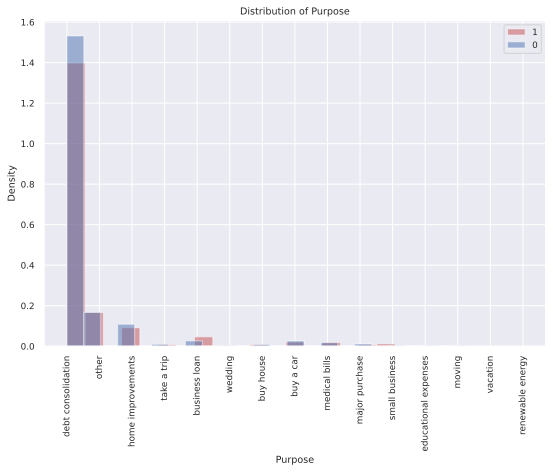

In [191]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1), 
             'Purpose'].hist(bins=25, xrot=90, color ='r', density=True, alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0), 
             'Purpose'].hist(bins=25, color ='b', density=True, alpha=0.5, label ='0')
plt.xlabel('Purpose')
plt.ylabel('Density')
plt.title('Distribution of Purpose')
plt.legend()
plt.show()

In [192]:
df_train.groupby('Purpose')['Credit Default'].mean().sort_values()

Purpose
educational expenses    0.100000
moving                  0.181818
major purchase          0.225000
buy a car               0.250000
vacation                0.250000
home improvements       0.262136
buy house               0.264706
wedding                 0.266667
take a trip             0.270270
debt consolidation      0.278264
other                   0.296241
medical bills           0.309859
business loan           0.426357
small business          0.538462
renewable energy        1.000000
Name: Credit Default, dtype: float64

*Проверим гипотезу о согласованности частот в Purpose, используя критерий Хи-квадрат Пирсона*

**Гипотеза** 

* Нулевая гипотеза: ожидаемые и наблюдаемые частоты согласованы
* Альтернативная гипотеза: отклонения в частотах выходят за рамки случайных колебаний, расхождения статистически значимы
* Критерий: Хи-квадрат Пирсона
* Уровень значимости $\normalsize \alpha$: 0.05

Объединим значения по группам, рассчитаем таблицы частот и проверим гипотезу для каждой из групп значений

In [193]:
business =  df_train['Purpose'].isin(['business loan', 'small business'])
medical = df_train['Purpose'].isin(['medical bills', 'other'])
personal = df_train['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',
                                     'buy house', 'home improvements', 'buy a car', 'vacation'])
other = df_train['Purpose'].isin(['educational expenses', 'moving', 'major purchase']) 

In [194]:
purpose_business_and_target = df_train.loc[business, ['Id', 'Purpose', 'Credit Default']]
purpose_medical_and_target = df_train.loc[medical, ['Id', 'Purpose', 'Credit Default']]
purpose_personal_and_target = df_train.loc[personal, ['Id', 'Purpose', 'Credit Default']]
purpose_other_and_target = df_train.loc[other, ['Id', 'Purpose', 'Credit Default']]
table1 = purpose_business_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table2 = purpose_medical_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table3 = purpose_personal_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')
table4 = purpose_other_and_target.pivot_table(values='Id', index='Purpose', columns='Credit Default', aggfunc='count')

In [195]:
chi2, p, _, _ = chi2_contingency(table1)
p

0.40483403834216214

In [196]:
chi2, p, _, _ = chi2_contingency(table2)
p

0.918726076937743

In [197]:
chi2, p, _, _ = chi2_contingency(table3)
p

0.988484448596236

In [198]:
chi2, p, _, _ = chi2_contingency(table4)
p

0.6670131614664776

P-value получилось больше выбранного уровня значимости, соответственно у нас нет оснований для отвержения нулевой гипотезы и можно допустить, что мы можем объединить категории соответствующим образом.

### Разбивка обучающей выборки

Разобьем тренировочный датасет на 2 набора - тренировочный и валидационный

In [199]:
full_train = df_train.copy()

In [200]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [201]:
df_train, df_valid = train_test_split(df_train, 
                                      shuffle=True, 
                                      test_size=0.3, 
                                      stratify=df_train['Credit Default'], 
                                      random_state=42)

In [202]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5250 entries, 2359 to 1780
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                5250 non-null   object 
 1   Annual Income                 4161 non-null   float64
 2   Years in current job          4986 non-null   object 
 3   Tax Liens                     5250 non-null   float64
 4   Number of Open Accounts       5250 non-null   float64
 5   Years of Credit History       5250 non-null   float64
 6   Maximum Open Credit           5250 non-null   float64
 7   Number of Credit Problems     5250 non-null   float64
 8   Months since last delinquent  2411 non-null   float64
 9   Bankruptcies                  5242 non-null   float64
 10  Purpose                       5250 non-null   object 
 11  Term                          5250 non-null   object 
 12  Current Loan Amount           5250 non-null   float64
 13  

In [203]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2250 entries, 1369 to 2867
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2250 non-null   object 
 1   Annual Income                 1782 non-null   float64
 2   Years in current job          2143 non-null   object 
 3   Tax Liens                     2250 non-null   float64
 4   Number of Open Accounts       2250 non-null   float64
 5   Years of Credit History       2250 non-null   float64
 6   Maximum Open Credit           2250 non-null   float64
 7   Number of Credit Problems     2250 non-null   float64
 8   Months since last delinquent  1008 non-null   float64
 9   Bankruptcies                  2244 non-null   float64
 10  Purpose                       2250 non-null   object 
 11  Term                          2250 non-null   object 
 12  Current Loan Amount           2250 non-null   float64
 13  

In [204]:
df_train['Credit Default'].value_counts(normalize=True)

0    0.718286
1    0.281714
Name: Credit Default, dtype: float64

In [205]:
df_valid['Credit Default'].value_counts(normalize=True)

0    0.718222
1    0.281778
Name: Credit Default, dtype: float64

### Обработка выбросов

* `Home Ownership`

Тип `Have Mortage` скорее всего то же самое, что и `Home Mortage`, объединим их

In [206]:
df_train['Home Ownership'].loc[df_train['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'
df_valid['Home Ownership'].loc[df_valid['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'

full_train['Home Ownership'].loc[full_train['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'
df_test['Home Ownership'].loc[df_test['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'

* `Purpose` - много категорий, сгруппируем их так, чтобы частота появления целевого события была примерно одинаковая.

* business - business loan, small business, renewable energy
* medical -  medical bills, other
* personal - take a trip, debt consolidation, wedding,  buy house, home improvements, buy a car,  vacation
* other - educational expenses, moving, major purchase 

In [207]:
def merge_purpose(df):
    df.loc[df['Purpose'].isin(['business loan', 'small business', 'renewable energy']), 'Purpose'] = 'business'
    df.loc[df['Purpose'].isin(['medical bills', 'other']), 'Purpose'] = 'medical'
    df.loc[df['Purpose'].isin(['take a trip', 'debt consolidation', 'wedding',  'buy house', 'home improvements', 'buy a car',  'vacation']), 'Purpose'] = 'personal'
    df.loc[df['Purpose'].isin(['educational expenses', 'moving', 'major purchase']), 'Purpose'] = 'other'

In [208]:
merge_purpose(df_train)
merge_purpose(df_valid)
merge_purpose(full_train)
merge_purpose(df_test)

In [209]:
df_test['Purpose'].value_counts()

personal    2185
medical      267
business      35
other         13
Name: Purpose, dtype: int64

In [210]:
df_train.groupby('Purpose')['Credit Default'].mean().sort_values()

Purpose
other       0.175000
personal    0.276967
medical     0.302326
business    0.428571
Name: Credit Default, dtype: float64

* `Maximum Open Credit` - есть нулевые значения, они противоречат значениям текущей задолженности. Они должны быть не меньше текущего долга

In [211]:
full_train[full_train['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,personal,Short Term,129734.0,19.0,17.0,NaN,0,8
91,Rent,601369.0,10+ years,0.0,6.0,16.9,0.0,0.0,14.0,0.0,personal,Short Term,165924.0,0.0,9021.0,738.0,0,91
196,Rent,815157.0,7 years,0.0,3.0,8.8,0.0,0.0,NaN,0.0,business,Short Term,218042.0,0.0,5855.0,738.0,0,196
294,Home Mortgage,2033931.0,7 years,0.0,6.0,21.1,0.0,0.0,NaN,0.0,personal,Short Term,108042.0,0.0,30340.0,742.0,0,294
309,Rent,1245792.0,3 years,0.0,5.0,22.4,0.0,0.0,58.0,0.0,other,Long Term,338096.0,0.0,395.0,659.0,0,309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6593,Home Mortgage,NaN,8 years,0.0,10.0,13.0,0.0,0.0,NaN,0.0,personal,Long Term,672078.0,19.0,8860.0,NaN,0,6593
6851,Home Mortgage,2251728.0,10+ years,0.0,8.0,15.4,0.0,0.0,NaN,0.0,personal,Long Term,760452.0,0.0,36778.0,725.0,0,6851
7014,Home Mortgage,1223771.0,5 years,0.0,9.0,24.0,0.0,0.0,NaN,0.0,business,Long Term,751454.0,0.0,15348.0,737.0,1,7014
7124,Rent,NaN,1 year,0.0,4.0,11.0,0.0,0.0,50.0,0.0,personal,Short Term,134024.0,0.0,0.0,NaN,0,7124


In [212]:
def outliers_max_open_credit(df):
    for i in range(0, len(df['Maximum Open Credit'].values)):
        if df['Maximum Open Credit'].values[i] == 0:
            df['Maximum Open Credit'].values[i] = df['Current Loan Amount'].values[i]

In [213]:
outliers_max_open_credit(df_train)
outliers_max_open_credit(df_valid)

outliers_max_open_credit(full_train)
outliers_max_open_credit(df_test)

In [214]:
full_train[full_train['Maximum Open Credit'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Id


* `Years in current job` - Объединим значения признака:
    - < 1 year & 1 year
    - 2 years, 3 years, 8 years
    - 5 years, 6 years, 7 years & 4 years
    - 10+ years & 9 years 

In [215]:
def merge_years_of_job(df):
    df.loc[df['Years in current job'].isin(['< 1 year', '1 year']), 'Years in current job'] = 1
    df.loc[df['Years in current job'].isin(['2 years', '3 years', '8 years']), 'Years in current job'] = 2
    df.loc[df['Years in current job'].isin(['4 years', '5 years', '6 years', '7 years']), 'Years in current job'] = 3
    df.loc[df['Years in current job'].isin(['10+ years', '9 years']), 'Years in current job'] = 4

In [216]:
merge_years_of_job(df_train)
merge_years_of_job(df_valid)
merge_years_of_job(full_train)
merge_years_of_job(df_test)
df_valid['Years in current job'].value_counts()

4    745
3    570
2    513
1    315
Name: Years in current job, dtype: int64

In [217]:
df_train['Years in current job'].value_counts()

4    1846
3    1237
2    1151
1     752
Name: Years in current job, dtype: int64

* `Current Loan Amount` - есть значения, равные 99999999.0, их 1167. Модель для заполнения этих значений работает значительно хуже, чем заполнение медианой. После изучения распределения значений можно сделать вывод, что данные значения указывают на принадлежность наблюдения к нулевому классу, следовательно, лучше эти данные либо оставить, как есть, либо сделать 0, так как у этих наблюдений задолженности нет (я выбрала последний вариант)

In [218]:
#  добавим биннарный признак для выбросов
# def big_current_loan_value(df):
#     df['Big Current Loan Amount'] = 0
#     df['Big Current Loan Amount'].loc[df['Big Current Loan Amount'].isnull()] = 1

In [219]:
# big_current_loan_value(df_train)
# big_current_loan_value(df_valid)
# big_current_loan_value(full_train)
# big_current_loan_value(df_test)

In [220]:
# Заменим на ноль
def fill_outliers_loan_amount(df):
    df.loc[df['Current Loan Amount'] == 99999999.0, 'Current Loan Amount'] = 0

In [221]:
fill_outliers_loan_amount(df_train)
fill_outliers_loan_amount(df_valid)
fill_outliers_loan_amount(full_train)
fill_outliers_loan_amount(df_test)

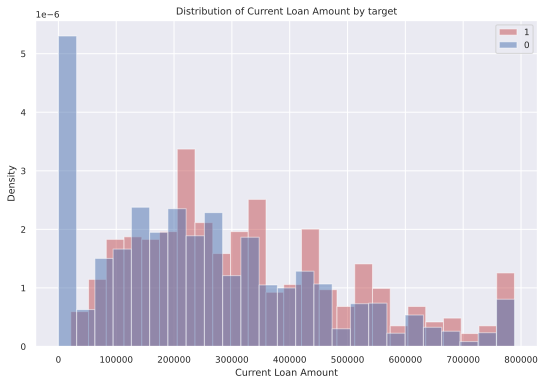

In [222]:
plt.figure(figsize = (9, 6))

df_train.loc[(df_train['Credit Default'] == 1) & (df_train['Current Loan Amount'] < 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[(df_train['Credit Default'] == 0) & (df_train['Current Loan Amount'] < 99999999.0), 'Current Loan Amount'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Current Loan Amount')
plt.ylabel('Density')
plt.title('Distribution of Current Loan Amount by target')
plt.legend()
plt.show()

* `Credit Score` - Выбросы больше 1000. Большинство значений являются событием 1 целевой переменной, то есть целевое событие, и их доля довольно большая (400 наблюдений, против 1184 в другом интервале), заменим их на 550 (минимальный балл), нулевые события - заменим на 750

In [223]:
df_train['Credit Score'].min()

585.0

Добавим дополнительный признак слишком большого значения Credit Score

In [224]:
def credit_score_outliers_column(df):
    df['Is Credit Score too large'] = 0
    df['Is Credit Score too large'].loc[df['Credit Score'] > 1000] = 1

In [225]:
credit_score_outliers_column(df_train)
credit_score_outliers_column(df_valid)
credit_score_outliers_column(full_train)
credit_score_outliers_column(df_test)

In [226]:
df_valid['Is Credit Score too large'].value_counts()

0    2123
1     127
Name: Is Credit Score too large, dtype: int64

In [227]:
def credit_score_outliers(train, test):
    train['Credit Score'].loc[(train['Credit Score'] > 750) & (train['Credit Default'] == 1) ] = 550
    train['Credit Score'].loc[(train['Credit Score'] > 750) & (train['Credit Default'] == 0) ] = 750
    test['Credit Score'].loc[test['Credit Score'] > 750] = 550

In [228]:
credit_score_outliers(df_train, df_valid)
credit_score_outliers(full_train, df_test)

In [229]:
df_train['Credit Score'].value_counts()

550.0    274
741.0    113
750.0    112
740.0    111
747.0    110
        ... 
591.0      1
629.0      1
655.0      1
614.0      1
615.0      1
Name: Credit Score, Length: 148, dtype: int64

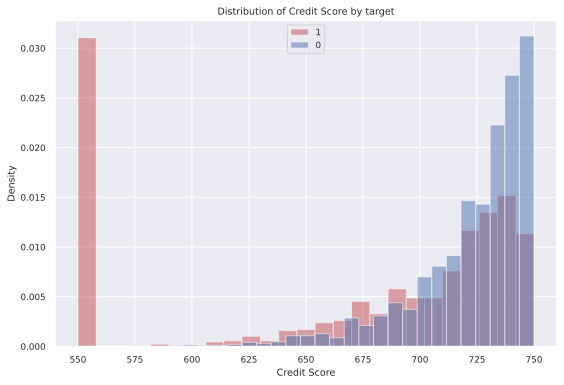

In [230]:
plt.figure(figsize = (9, 6))

df_train.loc[df_train['Credit Default'] == 1, 'Credit Score'].hist(bins=25, density=True, color ='r', alpha=0.5, label ='1')
df_train.loc[df_train['Credit Default'] == 0, 'Credit Score'].hist(bins=25, density=True, color ='b', alpha=0.5, label ='0')
plt.xlabel('Credit Score')
plt.ylabel('Density')
plt.title('Distribution of Credit Score by target')
plt.legend()
plt.show()

### Обработка пропусков 

* `Years in current job` - Заменим на самое популярное значение

In [231]:
def fillna_years_in_current_job(train, test):
    mode = train['Years in current job'].mode()[0]
    train['Years in current job'].loc[train['Years in current job'].isnull()] = mode
    test['Years in current job'].loc[test['Years in current job'].isnull()] = mode
    train['Years in current job'] = train['Years in current job'].astype(int)
    test['Years in current job'] = test['Years in current job'].astype(int)

In [232]:
fillna_years_in_current_job(df_train, df_valid)
fillna_years_in_current_job(full_train, df_test)

* `Months since last delinquent` - скорее всего это отсутствие просрочек, то есть 0, заменим Nan на 0

In [233]:
df_train['Months since last delinquent'].fillna(0, inplace=True)
df_valid['Months since last delinquent'].fillna(0, inplace=True)

full_train['Months since last delinquent'].fillna(0, inplace=True)
df_test['Months since last delinquent'].fillna(0, inplace=True)

* `Bankruptcies` - скорее всего пропуски это тоже нули, это самое популярное значение 

In [234]:
df_train['Bankruptcies'].fillna(0, inplace=True)
df_valid['Bankruptcies'].fillna(0, inplace=True)

full_train['Bankruptcies'].fillna(0, inplace=True)
df_test['Bankruptcies'].fillna(0, inplace=True)

### Обработка категориальных признаков

**Term**

In [235]:
def category_term(df):
    df['Term'] = df['Term'].map({'Short Term':'1', 'Long Term':'0'}).astype(int)

In [236]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2250 entries, 1369 to 2867
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2250 non-null   object 
 1   Annual Income                 1782 non-null   float64
 2   Years in current job          2250 non-null   int64  
 3   Tax Liens                     2250 non-null   float64
 4   Number of Open Accounts       2250 non-null   float64
 5   Years of Credit History       2250 non-null   float64
 6   Maximum Open Credit           2250 non-null   float64
 7   Number of Credit Problems     2250 non-null   float64
 8   Months since last delinquent  2250 non-null   float64
 9   Bankruptcies                  2250 non-null   float64
 10  Purpose                       2250 non-null   object 
 11  Term                          2250 non-null   object 
 12  Current Loan Amount           2250 non-null   float64
 13  

In [237]:
category_term(df_train)
category_term(df_valid)
category_term(full_train)
category_term(df_test)

In [238]:
df_valid['Term'].value_counts()

1    1667
0     583
Name: Term, dtype: int64

In [239]:
df_train.groupby('Term')['Credit Default'].mean()

Term
0    0.421749
1    0.232708
Name: Credit Default, dtype: float64

**Years in current job**

**Home Ownership, Purpose**

In [240]:
df_train.select_dtypes(include='object')

,Home Ownership,Purpose
2359,Home Mortgage,personal
2083,Home Mortgage,personal
6927,Own Home,personal
7449,Rent,personal
3979,Rent,personal
...,...,...
5879,Rent,personal
3899,Home Mortgage,personal
3280,Home Mortgage,medical
4876,Home Mortgage,personal


In [241]:
def category_objects(df):
    for cat_colname in df.select_dtypes(include='object'):
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    return df

In [242]:
df_train = category_objects(df_train)
df_valid = category_objects(df_valid)
full_train = category_objects(full_train)
df_test = category_objects(df_test)

#TODO Разобраться, почему не работает
# category_objects(df_valid)
# category_objects(full_train)
# category_objects(df_test)

### Заполнение нулей для Credit Score и Annual income

* `Annual income` - построим предсказательную модель для заполнения нулей 

In [243]:
#  добавим биннарный признак для пропущенных значений
def nan_income_column(df):
    df['Nan Annual Income'] = 0
    df['Nan Annual Income'].loc[df['Annual Income'].isnull()] = 1

In [244]:
nan_income_column(df_train)
nan_income_column(df_valid)
nan_income_column(full_train)
nan_income_column(df_test)

In [245]:
df_test['Nan Annual Income'].value_counts()

0    1987
1     513
Name: Nan Annual Income, dtype: int64

In [246]:
# добавим новый признак средней зарплаты в зависимости от стажа
def mean_income_column(train, test):
    gp = train.groupby(['Years in current job'])['Annual Income'].mean()
    train['Mean Income By Stage'] = train['Years in current job'].map(gp.to_dict())
    test['Mean Income By Stage'] = test['Years in current job'].map(gp.to_dict())

In [247]:
mean_income_column(df_train, df_valid)
mean_income_column(full_train, df_test)

In [248]:
df_train.columns.tolist()

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default',
 'Id',
 'Is Credit Score too large',
 'Home Ownership_Home Mortgage',
 'Home Ownership_Own Home',
 'Home Ownership_Rent',
 'Purpose_business',
 'Purpose_medical',
 'Purpose_other',
 'Purpose_personal',
 'Nan Annual Income',
 'Mean Income By Stage']

In [249]:
target_AI = 'Annual Income'
features_AI = ['Mean Income By Stage', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 
               'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Term', 
               'Current Loan Amount', 'Monthly Debt', 'Home Ownership_Home Mortgage',
               'Home Ownership_Own Home', 'Home Ownership_Rent']

X_train_AI = df_train[features_AI].loc[df_train['Annual Income'].notnull()]
y_train_AI = df_train[target_AI].loc[df_train['Annual Income'].notnull()]
X_test_AI = df_train[features_AI].loc[df_train['Annual Income'].isnull()]
X_test_AI2 = df_valid[features_AI].loc[df_valid['Annual Income'].isnull()]

X_train, X_test, y_train, y_test = train_test_split(X_train_AI, y_train_AI, shuffle=True, test_size=0.3, random_state=21)

In [250]:
catb_for_AI = CatBoostRegressor(eval_metric='R2',
                                n_estimators=350,
                                l2_leaf_reg=2,
                                max_depth=4,
                                learning_rate=0.026,
                                silent=True,
                                random_state=21)

catb_for_AI.fit(X_train, y_train)
y_train_pred = catb_for_AI.predict(X_train)
y_test_pred = catb_for_AI.predict(X_test)

# evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

catb_for_AI.fit(X_train_AI, y_train_AI)
# Y_test_AI = catb_for_AI.predict(X_test_AI)

In [251]:
df_train.loc[df_train['Annual Income'].isnull(), 'Annual Income'] = catb_for_AI.predict(X_test_AI)
df_valid.loc[df_valid['Annual Income'].isnull(), 'Annual Income'] = catb_for_AI.predict(X_test_AI2) 

In [252]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2250 entries, 1369 to 2867
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2250 non-null   object 
 1   Annual Income                 2250 non-null   float64
 2   Years in current job          2250 non-null   int64  
 3   Tax Liens                     2250 non-null   float64
 4   Number of Open Accounts       2250 non-null   float64
 5   Years of Credit History       2250 non-null   float64
 6   Maximum Open Credit           2250 non-null   float64
 7   Number of Credit Problems     2250 non-null   float64
 8   Months since last delinquent  2250 non-null   float64
 9   Bankruptcies                  2250 non-null   float64
 10  Purpose                       2250 non-null   object 
 11  Term                          2250 non-null   int64  
 12  Current Loan Amount           2250 non-null   float64
 13  

In [253]:
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2250 entries, 1369 to 2867
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2250 non-null   object 
 1   Annual Income                 2250 non-null   float64
 2   Years in current job          2250 non-null   int64  
 3   Tax Liens                     2250 non-null   float64
 4   Number of Open Accounts       2250 non-null   float64
 5   Years of Credit History       2250 non-null   float64
 6   Maximum Open Credit           2250 non-null   float64
 7   Number of Credit Problems     2250 non-null   float64
 8   Months since last delinquent  2250 non-null   float64
 9   Bankruptcies                  2250 non-null   float64
 10  Purpose                       2250 non-null   object 
 11  Term                          2250 non-null   int64  
 12  Current Loan Amount           2250 non-null   float64
 13  

In [254]:
# %%time
# params = {'learning_rate' : [0.03, 0.02, 0.025, 0.015],
#           'max_depth' : [3, 4, 5, 6],
#           'n_estimators' : [150, 200, 250, 300]}

# GridSearch = GridSearchCV(catb_for_AI, params, scoring='r2', 
#                           cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=21))
# GridSearch.fit(X_train, y_train)

# GridSearch.best_params_

In [255]:
# для основных датасетов

X_train_AI_f = full_train[features_AI].loc[full_train['Annual Income'].notnull()]
y_train_AI_f = full_train[target_AI].loc[full_train['Annual Income'].notnull()]
X_test_AI_f = full_train[features_AI].loc[full_train['Annual Income'].isnull()]
X_test_AI2_f = df_test[features_AI].loc[df_test['Annual Income'].isnull()]

catb_for_AI_full = CatBoostRegressor(eval_metric='R2',
                                n_estimators=350,
                                l2_leaf_reg=2,
                                max_depth=4,
                                learning_rate=0.026,
                                silent=True,
                                random_state=21)

catb_for_AI_full.fit(X_train_AI_f, y_train_AI_f)

full_train.loc[full_train['Annual Income'].isnull(), 'Annual Income'] = catb_for_AI_full.predict(X_test_AI_f)
df_test.loc[df_test['Annual Income'].isnull(), 'Annual Income'] = catb_for_AI_full.predict(X_test_AI2_f)

In [256]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

* `Credit Score` - заполнение медианой дает худшую метрику, чем заполнение моделью

Добавим биннарный признак для пропущенных значений

In [257]:
def nan_score_column(df):
    df['Nan Credit Score'] = 0
    df['Nan Credit Score'].loc[df['Credit Score'].isnull()] = 1

In [258]:
nan_score_column(df_train)
nan_score_column(df_valid)
nan_score_column(full_train)
nan_score_column(df_test)

Для пропущенных значений с известным значением Credit Default : заменим на 550, если целевая переменная 1, на 750, если целевая переменная 1

In [259]:
target_CS = 'Credit Score'
features_CS = ['Annual Income', 'Years in current job', 
               'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 
#                'Number of Credit Problems', 'Bankruptcies', 
               'Months since last delinquent',
               'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 
               'Mean Income By Stage', 
               'Is Credit Score too large']

X_train_CS = df_train[features_CS].loc[df_train['Credit Score'].notnull()]
y_train_CS = df_train[target_CS].loc[df_train['Credit Score'].notnull()]
X_test_CS = df_train[features_CS].loc[df_train['Credit Score'].isnull()]
X_test_CS2 = df_valid[features_CS].loc[df_valid['Credit Score'].isnull()]

X_train, X_test, y_train, y_test = train_test_split(X_train_CS, y_train_CS, shuffle=True, test_size=0.3, random_state=21)

In [260]:
catb_for_CS = CatBoostRegressor(eval_metric='R2', 
                                n_estimators=400,
                                max_depth=5,
                                learning_rate=0.045,
                                silent=True,
                                leaf_estimation_iterations=280,
                                random_state=21)

# catb_for_CS.fit(X_train, y_train)
# y_train_pred = catb_for_CS.predict(X_train)
# y_test_pred = catb_for_CS.predict(X_test)

# evaluate_preds(y_train, y_train_pred, y_test, y_test_pred)

catb_for_CS.fit(X_train_CS, y_train_CS)

In [261]:
# %%time
# params = {'learning_rate' : [0.03, 0.02, 0.025, 0.015],
#           'max_depth' : [3, 4, 5],
#           'n_estimators' : [150, 200, 250, 300, 350]}

# GridSearch = GridSearchCV(catb_for_CS, params, scoring='r2', 
#                           cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=21))
# GridSearch.fit(X_train, y_train)

# GridSearch.best_params_

In [262]:
feature_importances = pd.DataFrame(zip(X_train_CS.columns, catb_for_CS.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
11,Is Credit Score too large,74.871211
6,Term,7.306385
4,Maximum Open Credit,4.259841
7,Current Loan Amount,2.668965
8,Current Credit Balance,2.185790
0,Annual Income,1.840819
3,Years of Credit History,1.764001
9,Monthly Debt,1.595225
2,Number of Open Accounts,1.471450
5,Months since last delinquent,1.237417


In [263]:
df_train.loc[df_train['Credit Score'].isnull(), 'Credit Score'] = catb_for_CS.predict(X_test_CS)
df_valid.loc[df_valid['Credit Score'].isnull(), 'Credit Score'] = catb_for_CS.predict(X_test_CS2) 

In [265]:
# для основных датасетов

X_train_CS = full_train[features_CS].loc[full_train['Credit Score'].notnull()]
y_train_CS = full_train[target_CS].loc[full_train['Credit Score'].notnull()]
X_test_CS = full_train[features_CS].loc[full_train['Credit Score'].isnull()]
X_test_CS2 = df_test[features_CS].loc[df_test['Credit Score'].isnull()]

catb_for_CS_full = CatBoostRegressor(eval_metric='R2', 
                                n_estimators=400,
                                max_depth=5,
                                learning_rate=0.045,
                                silent=True,
                                leaf_estimation_iterations=280,
                                random_state=21)

catb_for_CS_full.fit(X_train_CS, y_train_CS)

full_train.loc[full_train['Credit Score'].isnull(), 'Credit Score'] = catb_for_CS_full.predict(X_test_CS)
df_test.loc[df_test['Credit Score'].isnull(), 'Credit Score'] = catb_for_CS_full.predict(X_test_CS2)

In [266]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   int64  
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [267]:
class DataPreprocessing:
    """General preprocessing"""

    def __init__(self):
        """Class parameters"""
        self.medians = None
        self.modes = None
        self.gp_annual_income = None

    @staticmethod
    def fill_to_zero(X, columns):
        for column in columns:
            X[column].fillna(0, inplace=True)

    @staticmethod
    def gap_binary_feature(X, column):
        X[f'Nan {column}'] = 0
        X[f'Nan {column}'].loc[X[column].isnull()] = 1

    def fit(self, X):
        """Save statistics"""
        self.medians = X.median()
        self.modes = X.mode().loc[0]
        self.gp_annual_income = X.groupby(['Years in current job'])['Annual Income'].mean()

    def transform(self, X):
        """Transform data"""
        # Home Ownership
        X['Home Ownership'].loc[X['Home Ownership'] == 'Have Mortgage'] = 'Home Mortgage'
        #
        # Purpose
        X.loc[X['Purpose'].isin(['business loan', 'small business', 'renewable energy']), 'Purpose'] = 'business'
        X.loc[X['Purpose'].isin(['medical bills', 'other']), 'Purpose'] = 'medical'
        X.loc[X['Purpose'].isin(
            ['take a trip', 'debt consolidation', 'wedding', 'buy house', 'home improvements', 'buy a car',
             'vacation']), 'Purpose'] = 'personal'
        X.loc[X['Purpose'].isin(['educational expenses', 'moving', 'major purchase']), 'Purpose'] = 'other'

        # Maximum Open Credit
        for i in range(0, len(X['Maximum Open Credit'].values)):
            if X['Maximum Open Credit'].values[i] == 0:
                X['Maximum Open Credit'].values[i] = X['Current Loan Amount'].values[i]

        X['Years in current job'].loc[X['Years in current job'].isnull()] = self.modes['Years in current job']
        X['Years in current job'] = X['Years in current job'].map({'< 1 year': '1',
                                                                   '1 year': '1', 
                                                                   '2 years': '2',
                                                                   '3 years': '2',
                                                                   '8 years': '2',
                                                                   '4 years': '3',
                                                                   '5 years': '3',
                                                                   '6 years': '3', 
                                                                   '7 years': '3',
                                                                   '10+ years': '4',
                                                                   '9 years': '4'
                                                                  }).astype(int)
        X['Years in current job'] = X['Years in current job'].astype(int)

        # Current Loan Amount
        X['Current Loan Amount'].loc[X['Current Loan Amount'] == 99999999.0] = 0

        # Credit Score - outliers column
        X['Is Credit Score too large'] = 0
        X['Is Credit Score too large'].loc[X['Credit Score'] > 1000] = 1
        
        # Credit Score
        try:
            X['Credit Score'].loc[(X['Credit Score'] > 750) & (X['Credit Default'] == 1)] = 550
            X['Credit Score'].loc[(X['Credit Score'] > 750) & (X['Credit Default'] == 0)] = 750
        except KeyError:
            X['Credit Score'].loc[X['Credit Score'] > 750] = 550
        
        """Gap processing"""

        # Months since last delinquent, Bankruptcies
        self.fill_to_zero(X, ['Months since last delinquent', 'Bankruptcies'])

        # Term
        X['Term'] = X['Term'].map({'Short Term': '1', 'Long Term': '0'}).astype(int)

        # Home Ownership, Purpose
        for cat_colname in X.select_dtypes(include='object'):
            X = pd.concat([X, pd.get_dummies(X[cat_colname], prefix=cat_colname)], axis=1)

        # Nan feature
        self.gap_binary_feature(X, 'Annual Income')
        #
        # New feature Mean Income By Stage
        X['Mean Income By Stage'] = X['Years in current job'].map(self.gp_annual_income.to_dict())

        # Nan feature
        self.gap_binary_feature(X, 'Credit Score')

        X.fillna(self.medians, inplace=True)
        return X

In [268]:
class AnnualIncomeFilling:
    """Filling Nan values for Allual Income field"""

    def __init__(self):
        """Parameters for model Annual Income"""
        self.target_AI = 'Annual Income'
        self.features_AI = ['Mean Income By Stage', 'Years in current job', 'Tax Liens', 'Number of Open Accounts',
                            'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies', 'Term',
                            'Current Loan Amount', 'Monthly Debt',
                            'Home Ownership_Home Mortgage', 'Home Ownership_Own Home', 'Home Ownership_Rent']
        self.X_train_AI = None
        self.y_train_AI = None
        self.X_test_AI = None
        self.catb_for_AI = None

    def fit_(self, X):
        self.X_train_AI = X[self.features_AI].loc[X['Annual Income'].notnull()]
        self.y_train_AI = X[self.target_AI].loc[X['Annual Income'].notnull()]
        self.catb_for_AI = CatBoostRegressor(eval_metric='R2',
                                             n_estimators=350,
                                             l2_leaf_reg=2,
                                             max_depth=4,
                                             learning_rate=0.026,
                                             silent=True,
                                             random_state=21)

        self.catb_for_AI.fit(self.X_train_AI, self.y_train_AI)

    def transform_(self, X):
        # Model for Annual Income
        self.X_test_AI = X[self.features_AI].loc[X['Annual Income'].isnull()]
        X.loc[X['Annual Income'].isnull(), 'Annual Income'] = self.catb_for_AI.predict(self.X_test_AI)
        

In [269]:
class CreditScoreFilling:
    """Filling Nan values for Credit Score field"""

    def __init__(self):
        """Parameters for model Credit Score"""
        self.target_CS = 'Credit Score'
        self.features_CS = ['Annual Income', 'Years in current job',
                            'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                            'Months since last delinquent', 'Term', 'Current Loan Amount',
                            'Current Credit Balance', 'Monthly Debt', 'Mean Income By Stage',
                            'Is Credit Score too large']
        self.X_train_CS = None
        self.y_train_CS = None
        self.X_test_CS = None
        self.catb_for_CS = None

    def fit(self, X):
        self.X_train_CS = X[self.features_CS].loc[X['Credit Score'].notnull()]
        self.y_train_CS = X[self.target_CS].loc[X['Credit Score'].notnull()]
        self.catb_for_CS = CatBoostRegressor(eval_metric='R2',
                                             n_estimators=400,
                                             max_depth=5,
                                             learning_rate=0.045,
                                             silent=True,
                                             leaf_estimation_iterations=280,
                                             random_state=21)
        self.catb_for_CS.fit(self.X_train_CS, self.y_train_CS)

    def predict(self, X):
        # Model for Credit Score
        self.X_test_CS = X[self.features_CS].loc[X['Credit Score'].isnull()]
        X.loc[X['Credit Score'].isnull(), 'Credit Score'] = self.catb_for_CS.predict(self.X_test_CS)

### Построение новых признаков

* `Class Credit Score` - разделим на группы по интервалам

In [270]:
def column_class_credit_score(df):
    df['Class Credit Score'] = 0
    df['Class Credit Score'].loc[df['Credit Score'] < 600] = 1
    df['Class Credit Score'].loc[(df['Credit Score'] >= 600) & (df['Credit Score'] < 650)] = 2
    df['Class Credit Score'].loc[(df['Credit Score'] >= 650) & (df['Credit Score'] < 700)] = 3
    df['Class Credit Score'].loc[(df['Credit Score'] >= 700) & (df['Credit Score'] < 725)] = 4
    df['Class Credit Score'].loc[(df['Credit Score'] >= 725) & (df['Credit Score'] < 750)] = 5
    df['Class Credit Score'].loc[df['Credit Score']  >= 750] = 6

In [271]:
column_class_credit_score(df_train)
column_class_credit_score(df_valid)
column_class_credit_score(full_train)
column_class_credit_score(df_test)

In [272]:
df_valid['Class Credit Score'].value_counts()

5    1134
4     586
3     317
1     145
2      39
6      29
Name: Class Credit Score, dtype: int64

* `Monthly Income` - ежемесячный доход

In [273]:
def monthly_income(df):
    df['Monthly Income'] = df['Annual Income'] / 12

In [274]:
monthly_income(df_train)
monthly_income(df_valid)
monthly_income(full_train)
monthly_income(df_test)

In [275]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   int64  
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

* `Mean Credit Score in Class` - средний кредитный бал, в зависимости от стажа

In [276]:
def score_in_class(train, test):
    gp = train.groupby(['Class Credit Score'])['Credit Score'].mean()
    train["Mean Credit Score In Class"] = train['Class Credit Score'].map(gp.to_dict())
    test["Mean Credit Score In Class"] = test['Class Credit Score'].map(gp.to_dict())

In [277]:
score_in_class(df_train, df_valid)
score_in_class(full_train, df_test)

* `Class Current Loan`

In [278]:
def column_class_current_loan(df):
    df['Class Current Loan'] = 0
    df['Class Current Loan'].loc[df['Current Loan Amount'] < 100000] = 1
    df['Class Current Loan'].loc[(df['Current Loan Amount'] >= 100000) & (df['Current Loan Amount'] < 200000)] = 2
    df['Class Current Loan'].loc[(df['Current Loan Amount'] >= 200000) & (df['Current Loan Amount'] < 300000)] = 3
    df['Class Current Loan'].loc[(df['Current Loan Amount'] >= 400000) & (df['Current Loan Amount'] < 500000)] = 4
    df['Class Current Loan'].loc[(df['Current Loan Amount'] >= 500000) & (df['Current Loan Amount'] < 600000)] = 5
    df['Class Current Loan'].loc[df['Current Loan Amount']  >= 600000] = 6

In [279]:
column_class_current_loan(df_train)
column_class_current_loan(df_valid)
column_class_current_loan(full_train)
column_class_current_loan(df_test)

* `Monthly Income and Debt Diff` - разница между зп и долгом

In [280]:
def income_and_debt_diff(df):
    df['Monthly Income and Debt Diff'] = df['Monthly Income'] - df['Monthly Debt']

In [281]:
income_and_debt_diff(df_train)
income_and_debt_diff(df_valid)
income_and_debt_diff(full_train)
income_and_debt_diff(df_test)

* `Current Loan and Monthly Income Diff` - разница между зп и долгом

In [282]:
def loan_and_income_diff(df):
    df['Current Loan and Monthly Income Diff'] = df['Current Loan Amount'] - df['Monthly Income']

In [283]:
loan_and_income_diff(df_train)
loan_and_income_diff(df_valid)
loan_and_income_diff(full_train)
loan_and_income_diff(df_test)

* `Low Credit Score`

In [284]:
def low_score(df):
    df['Low Credit Score'] = (df['Credit Score'] < 675).astype('int64')

In [285]:
low_score(df_train)
low_score(df_valid)
low_score(full_train)
low_score(df_test)

In [286]:
df_valid['Low Credit Score'].value_counts()

0    1987
1     263
Name: Low Credit Score, dtype: int64

* `Big Loan Amount` - большая сумма задолженности

In [287]:
def big_loan(df):
    df['Big Loan Amount'] = (df['Current Loan Amount'] > 200000).astype('int64')

In [288]:
big_loan(df_train)
big_loan(df_valid)
big_loan(full_train)
big_loan(df_test)

* Feature Tools - сработало не очень хорошо, но попробую еще 

In [289]:
# import featuretools as ft
# import featuretools.variable_types as vtypes

# # creating and entity set 'es'
# es = ft.EntitySet(id='Credits')
# es

In [290]:
# df_train['Id'] = df_train.index
# df_valid['Id'] = df_valid.index
# full_train['Id'] = full_train.index
# df_test['Id'] = df_test.index

In [291]:
# df_train.columns

In [292]:
# # adding a dataframe 
# cols = ['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
#        'Number of Open Accounts', 'Years of Credit History',
#        'Maximum Open Credit', 'Number of Credit Problems',
#        'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
#        'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
#        'Credit Score', 'Big Current Loan Amount', 'Is Credit Score too large', 'Nan Annual Income', 
#         'Mean Income By Stage', 'Nan Credit Score', 'Class Credit Score', 'Monthly Income', 
#         'Mean Credit Score In Class', 'Monthly Income and Debt Diff ', 'Low Credit Score', 
#         'Big Loan Amount']

# variable_types = {
#     'Home Ownership': vtypes.Categorical,
#     'Years in current job': vtypes.Categorical,
#     'Tax Liens': vtypes.Categorical,
#     'Purpose': vtypes.Categorical,
#     'Term': vtypes.Categorical
# }

# es.entity_from_dataframe(entity_id='Clients',
#                          dataframe=df_train[cols],
#                          index='Id',
#                          variable_types=variable_types)

# es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Credit Score', index='Credit Score')
# es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Current Loan Amount', index='Current Loan Amount')
# es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Annual Income', index='Annual Income')

In [293]:
# feature_matrix, feature_names = ft.dfs(entityset=es, 
#                                        target_entity='Clients',
#                                        verbose=3)

In [294]:
# es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Credit Score', index='Credit Score')
# es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Current Loan Amount', index='Current Loan Amount')
# es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Annual Income', index='Annual Income')

# es

In [295]:
# feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [296]:
# train_featured = feature_matrix_enc.copy()
# train_featured.shape

test

In [297]:
# # test

# es_tst = ft.EntitySet(id='Credits')

# es_tst.entity_from_dataframe(entity_id='Clients',
#                              dataframe=df_valid[cols],
#                              index='Id')

# es_tst = es_tst.normalize_entity(base_entity_id='Clients', new_entity_id='Credit Score', index='Credit Score')
# es_tst = es_tst.normalize_entity(base_entity_id='Clients', new_entity_id='Current Loan Amount', index='Current Loan Amount')
# es_tst = es_tst.normalize_entity(base_entity_id='Clients', new_entity_id='Annual Income', index='Annual Income')
# # es_tst

# test_featured = ft.calculate_feature_matrix(features=features_enc, entityset=es_tst)
# test_featured

In [298]:
# # final train

# es_f = ft.EntitySet(id='Credits')

# es_f.entity_from_dataframe(entity_id='Clients',
#                              dataframe=full_train[cols],
#                              index='Id')

# es_f = es_f.normalize_entity(base_entity_id='Clients', new_entity_id='Credit Score', index='Credit Score')
# es_f = es_f.normalize_entity(base_entity_id='Clients', new_entity_id='Current Loan Amount', index='Current Loan Amount')
# es_f = es_f.normalize_entity(base_entity_id='Clients', new_entity_id='Annual Income', index='Annual Income')
# # es_tst

# f_train_featured = ft.calculate_feature_matrix(features=features_enc, entityset=es_f)
# f_train_featured

In [299]:
# # final test

# es_tst_f = ft.EntitySet(id='Credits')

# es_tst_f.entity_from_dataframe(entity_id='Clients',
#                              dataframe=df_test[cols],
#                              index='Id')

# es_tst_f = es_tst_f.normalize_entity(base_entity_id='Clients', new_entity_id='Credit Score', index='Credit Score')
# es_tst_f = es_tst_f.normalize_entity(base_entity_id='Clients', new_entity_id='Current Loan Amount', index='Current Loan Amount')
# es_tst_f = es_tst_f.normalize_entity(base_entity_id='Clients', new_entity_id='Annual Income', index='Annual Income')
# # es_tst

# f_test_featured = ft.calculate_feature_matrix(features=features_enc, entityset=es_tst_f)
# f_test_featured

In [300]:
# X_train = train_featured
# y_train = df_train['Credit Default']

# X_test = test_featured
# y_test = df_valid['Credit Default']

# new_features = X_train.columns

In [301]:
# catb = CatBoostClassifier(learning_rate=0.035, 
#                           max_depth=4,
#                           n_estimators=400,
#                           use_best_model=True,
#                           class_weights=[1, disbalance],
#                           silent=True,                           
#                           random_state=21)

# catb.fit(X_train, y_train, 
# #          plot=True, 
#          eval_set=(X_test, y_test))

# y_train_pred = catb.predict(X_train)
# y_test_pred = catb.predict(X_test)
# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [302]:
class FeatureGenerator:
    """Generate new features"""

    def __init__(self):
        self.gp_credit_score = None

    def fit(self, X):
        X = X.copy()
        self.gp_credit_score = X.groupby(['Class Credit Score'])['Credit Score'].mean()
        return X

    def transform(self, X):
        # Class Credit Score
        X['Class Credit Score'] = 0
        X['Class Credit Score'].loc[X['Credit Score'] < 600] = 1
        X['Class Credit Score'].loc[(X['Credit Score'] >= 600) & (X['Credit Score'] < 650)] = 2
        X['Class Credit Score'].loc[(X['Credit Score'] >= 650) & (X['Credit Score'] < 700)] = 3
        X['Class Credit Score'].loc[(X['Credit Score'] >= 700) & (X['Credit Score'] < 725)] = 4
        X['Class Credit Score'].loc[(X['Credit Score'] >= 725) & (X['Credit Score'] < 750)] = 5
        X['Class Credit Score'].loc[X['Credit Score'] >= 750] = 6

        # Monthly Income
        X['Monthly Income'] = X['Annual Income'] / 12

        # Mean Credit Score in Class
        X["Mean Credit Score In Class"] = X['Class Credit Score'].map(self.gp_credit_score.to_dict())

        # Class Current Loan
        X['Class Current Loan'] = 0
        X['Class Current Loan'].loc[X['Current Loan Amount'] < 100000] = 1
        X['Class Current Loan'].loc[(X['Current Loan Amount'] >= 100000) & (X['Current Loan Amount'] < 200000)] = 2
        X['Class Current Loan'].loc[(X['Current Loan Amount'] >= 200000) & (X['Current Loan Amount'] < 300000)] = 3
        X['Class Current Loan'].loc[(X['Current Loan Amount'] >= 400000) & (X['Current Loan Amount'] < 500000)] = 4
        X['Class Current Loan'].loc[(X['Current Loan Amount'] >= 500000) & (X['Current Loan Amount'] < 600000)] = 5
        X['Class Current Loan'].loc[X['Current Loan Amount'] >= 600000] = 6

        # Monthly Income and Debt Diff
        X['Monthly Income and Debt Diff '] = X['Monthly Income'] - X['Monthly Debt']

        # Current Loan and Monthly Income Diff
        X['Current Loan and Monthly Income Diff'] = X['Current Loan Amount'] - X['Monthly Income']

        # Low Credit Score
        X['Low Credit Score'] = (X['Credit Score'] < 675).astype('int64')

        # Big Loan Amount
        X['Big Loan Amount'] = (X['Current Loan Amount'] > 200000).astype('int64')
        return X

### Сохранение обучающего датасета

In [303]:
def save(df, PATH):
    df.to_csv(PATH, index=False, encoding='utf-8', sep=';')

In [304]:
save(full_train, PREPARED_TRAIN_DATASET_PATH)
save(df_test, PREPARED_TEST_DATASET_PATH)

### Выделение целевой переменной и групп признаков

In [305]:
TARGET = 'Credit Default'

BASE_FEATURE_NAMES = ['Annual Income', 
                      'Years in current job', 
                      'Tax Liens',
                      'Number of Open Accounts', 
                      'Years of Credit History',
                      'Maximum Open Credit', 
                      'Number of Credit Problems',
#                       'Months since last delinquent', 
                      'Bankruptcies', 
                      'Term',
                      'Current Loan Amount', 
                      'Current Credit Balance', 
                      'Monthly Debt',
                      'Credit Score']

NEW_FEATURE_NAMES = [
                     'Is Credit Score too large',
                     'Home Ownership_Home Mortgage',
                     'Home Ownership_Own Home',
                     'Home Ownership_Rent',
                     'Purpose_business',
                     'Purpose_medical',
                     'Purpose_other',
                     'Purpose_personal',
                     'Nan Annual Income',
                     'Mean Income By Stage',
                     'Nan Credit Score',
                     'Class Credit Score',
                     'Monthly Income',
                     'Mean Credit Score In Class',
                     'Monthly Income and Debt Diff',
                     'Low Credit Score',
                     'Big Loan Amount',
                     'Current Loan and Monthly Income Diff',
                     'Class Current Loan'
]


### Разбиение на train и test

In [306]:
X = df_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
y = df_train[TARGET]

X_train = df_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
X_test = df_valid[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
y_train = df_train[TARGET]
y_test = df_valid[TARGET]

### Балансировка целевой переменной

Были попробованы все способы балансировки, все они дают метрику хуже, чем встроенная в CatBoost балансировка, для финальной модели будем использовать ее.

In [307]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET, method='tomek')
    
df_balanced[TARGET].value_counts()

0    3255
1    1479
Name: Credit Default, dtype: int64

In [308]:
X_train_b = df_balanced.drop(columns=TARGET)
y_train_b = df_balanced[TARGET]

### Построение и оценка базовых моделей

**CatBoost**

In [309]:
# базовая модель Catboost
catb = CatBoostClassifier(silent=True,
                          class_weights=[1, disbalance],
                          random_state=21)
catb.fit(X_train, y_train)

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3771
           1       0.78      0.90      0.84      1479

    accuracy                           0.90      5250
   macro avg       0.87      0.90      0.88      5250
weighted avg       0.91      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.78      0.80      1616
           1       0.49      0.56      0.53       634

    accuracy                           0.71      2250
   macro avg       0.66      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1253  363
1                279  355


In [310]:
# базовая модель Catboost с балансировкой Tomek
catb = CatBoostClassifier(silent=True, random_state=21)
catb.fit(X_train_b, y_train_b)

y_train_pred = catb.predict(X_train_b)
y_test_pred = catb.predict(X_test)

get_classification_report(y_train_b, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3255
           1       0.96      0.64      0.77      1479

    accuracy                           0.88      4734
   macro avg       0.91      0.82      0.85      4734
weighted avg       0.89      0.88      0.87      4734

TEST

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1616
           1       0.64      0.40      0.49       634

    accuracy                           0.77      2250
   macro avg       0.72      0.66      0.67      2250
weighted avg       0.75      0.77      0.75      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1469  147
1                378  256


In [313]:
# базовая модель XGBoost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

xgbc = XGBClassifier(random_state=21)
xgbc.fit(X_train, y_train)

y_train_pred = xgbc.predict(X_train)
y_test_pred = xgbc.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[22:28:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      3771
           1       1.00      0.92      0.96      1479

    accuracy                           0.98      5250
   macro avg       0.98      0.96      0.97      5250
weighted avg       0.98      0.98      0.98      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1616
           1       0.59      0.37      0.45       634

    accuracy                           0.75      2250
   macro avg       0.69      0.63      0.64      2250
weighted avg       0.73      0.75      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0          

**LightGBM**

In [314]:
model_lgbm = LGBMClassifier(random_state=21, 
                            class_weight={0:1, 1:disbalance},
                            n_estimators=300,
                            boosting_type='dart',
                            max_depth=3,
                            learning_rate=0.085
                                )
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3771
           1       0.54      0.71      0.61      1479

    accuracy                           0.75      5250
   macro avg       0.71      0.74      0.71      5250
weighted avg       0.78      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.73      0.78      1616
           1       0.49      0.65      0.56       634

    accuracy                           0.71      2250
   macro avg       0.67      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1183  433
1                221  413


In [315]:
# %%time

# catb = CatBoostClassifier(
# #                           use_best_model=True,
#                           class_weights=[1, disbalance],
#                           silent=True,                           
#                           random_state=21)

# params = {'learning_rate' : [0.035, 0.03, 0.025, 0.02],
#           'max_depth' : [3, 4, 5],
#           'n_estimators' : [300, 350, 400, 450, 500]}

# GridSearch = GridSearchCV(catb, params, scoring='f1', 
#                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21))
# GridSearch.fit(X_train, y_train)

# GridSearch.best_params_

In [316]:
# %%time
# RandomizedSearch = RandomizedSearchCV(catb, params, scoring='f1', 
#                           cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21))
# RandomizedSearch.fit(X_train, y_train)

# RandomizedSearch.best_params_

In [317]:
catb = CatBoostClassifier(learning_rate=0.03, 
                          max_depth=4,
                          n_estimators=400,
#                           use_best_model=True,
                          class_weights=[1, disbalance],
                          silent=True,                           
                          random_state=21)

catb.fit(X_train, y_train, 
#          plot=True, 
#          eval_set=(X_test, y_test)
        )

y_train_pred = catb.predict(X_train)
y_test_pred = catb.predict(X_test)
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      3771
           1       0.56      0.74      0.64      1479

    accuracy                           0.76      5250
   macro avg       0.72      0.76      0.73      5250
weighted avg       0.79      0.76      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1616
           1       0.49      0.65      0.56       634

    accuracy                           0.71      2250
   macro avg       0.67      0.69      0.67      2250
weighted avg       0.74      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1188  428
1                221  413


In [318]:
cv_score = cross_val_score(
    catb,
    X_train,
    y_train,
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.55588235, 0.49327354, 0.54599407, 0.55967078, 0.54545455])

Со встроенной балансировкой метрика лучше

In [319]:
feature_importances = pd.DataFrame(zip(X_train.columns, catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
9,Current Loan Amount,23.512284
24,Class Credit Score,15.736398
26,Mean Credit Score In Class,15.142505
12,Credit Score,8.913638
30,Current Loan and Monthly Income Diff,7.136077
27,Monthly Income and Debt Diff,3.350192
11,Monthly Debt,3.346038
5,Maximum Open Credit,2.628618
8,Term,2.386381
4,Years of Credit History,2.281107


In [320]:
# Выбор отсечки

y_test_pred_probs = catb.predict_proba(X_test)
y_test_pred = np.where(y_test_pred_probs[:, 1] > 0.43, 1, 0)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      3771
           1       0.56      0.74      0.64      1479

    accuracy                           0.76      5250
   macro avg       0.72      0.76      0.73      5250
weighted avg       0.79      0.76      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.88      0.56      0.69      1616
           1       0.42      0.80      0.55       634

    accuracy                           0.63      2250
   macro avg       0.65      0.68      0.62      2250
weighted avg       0.75      0.63      0.65      2250

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               912  704
1               127  507


In [321]:
f1_score(y_test, y_test_pred, average=None)

array([0.68700565, 0.5495935 ])

In [322]:
feature_importances = pd.DataFrame(zip(X_train.columns, catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
9,Current Loan Amount,23.512284
24,Class Credit Score,15.736398
26,Mean Credit Score In Class,15.142505
12,Credit Score,8.913638
30,Current Loan and Monthly Income Diff,7.136077
27,Monthly Income and Debt Diff,3.350192
11,Monthly Debt,3.346038
5,Maximum Open Credit,2.628618
8,Term,2.386381
4,Years of Credit History,2.281107


In [323]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 37 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Home Ownership                        7500 non-null   object 
 1   Annual Income                         7500 non-null   float64
 2   Years in current job                  7500 non-null   int64  
 3   Tax Liens                             7500 non-null   float64
 4   Number of Open Accounts               7500 non-null   float64
 5   Years of Credit History               7500 non-null   float64
 6   Maximum Open Credit                   7500 non-null   float64
 7   Number of Credit Problems             7500 non-null   float64
 8   Months since last delinquent          7500 non-null   float64
 9   Bankruptcies                          7500 non-null   float64
 10  Purpose                               7500 non-null   object 
 11  Term             

### Подбор оптимального размера выборки, кривая обучения

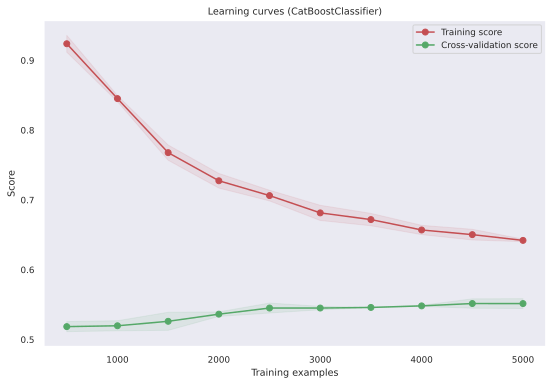

In [324]:
X = full_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]
y = full_train['Credit Default']
show_learning_curve_plot(catb, X, y)

По кривой обучения видно, что модель лучше обучается на всей выборке, следовательно, не нужно сокращать число наблюдений, передаваемых в обучение.

In [325]:
y_test_pred_probs = catb.predict_proba(X_test)
y_test_pred_probs

array([[0.70482708, 0.29517292],
       [0.01761823, 0.98238177],
       [0.5157241 , 0.4842759 ],
       ...,
       [0.31458754, 0.68541246],
       [0.48039355, 0.51960645],
       [0.26716839, 0.73283161]])

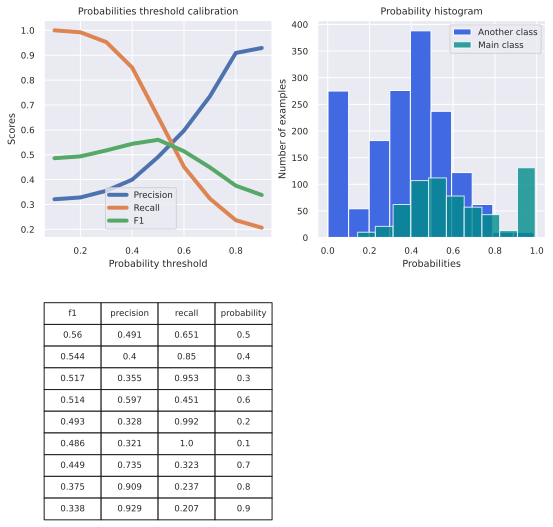

In [326]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

### Сделаем предсказания на тестовых данных

In [327]:
y_train_fin = full_train['Credit Default']

X_train_fin = full_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]

X_test_fin = df_test[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES]

catb = CatBoostClassifier(learning_rate=0.03, 
                          max_depth=4,
                          n_estimators=400,
                          class_weights=[1, disbalance],
                          silent=True,                           
                          random_state=21)

catb.fit(X_train_fin, y_train_fin)

y_test_fin = catb.predict(X_test_fin)

# Выбор отсечки

y_test_pred_probs = catb.predict_proba(X_test_fin)
y_test_fin = np.where(y_test_pred_probs[:, 1] > 0.43, 1, 0)

### Перекрестная проверка

In [328]:
cv_score = cross_val_score(
    catb,
    full_train[BASE_FEATURE_NAMES + NEW_FEATURE_NAMES],
    full_train[TARGET],
    scoring='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.54124748, 0.58458458, 0.54120041, 0.55137335, 0.53728294])

In [329]:
cv_score.mean() - cv_score.std(), cv_score.mean() + cv_score.std()

(0.5337753217841922, 0.5685001842502951)

In [330]:
cv_score.mean()

0.5511377530172437

In [331]:
CreditDefault_pred = pd.DataFrame({'Id': np.arange(0,y_test_fin.shape[0]), 'Credit Default': y_test_fin})
CreditDefault_pred.to_csv('Sokolova_predictions.csv', index=False, encoding='utf-8', sep=',')
CreditDefault_pred.head(10)

,Id,Credit Default
0,0,1
1,1,1
2,2,1
3,3,0
4,4,0
5,5,1
6,6,1
7,7,1
8,8,1
9,9,0


In [332]:
CreditDefault_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Id              2500 non-null   int64
 1   Credit Default  2500 non-null   int64
dtypes: int64(2)
memory usage: 39.2 KB


In [333]:
pickle.dump(
    catb, open("model.pkl", "wb")
)

In [334]:
!pwd

/home/katrinka/projects/Classification project
